# Afriat

In [1]:
ood_seed = 13

In [2]:
num_ood = 1  # not functioning

In [3]:
import cpa

[rank: 0] Global seed set to 0


In [4]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False

In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [6]:
adata_file_path = os.path.join("/home/icb/kemal.inecik/lustre_workspace/tardis_data/processed", "biolord_afriat.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
adata.obs["time_cat"] = adata.obs["time_cat"].astype(str).astype(float).astype(int).astype(str).astype("category")
adata

AnnData object with n_obs × n_vars = 19053 × 5000
    obs: 'mouse', 'experiment', 'time_int', 'time_cat', 'zone', 'status_control'

In [7]:
df = adata.obs.groupby(['time_cat', 'zone', 'status_control']).size()
availables = list(df[df>100].index)
availables, len(availables)

([('0', 'Pericentral', 'Control'),
  ('0', 'Periportal', 'Control'),
  ('12', 'Pericentral', 'Infected'),
  ('12', 'Pericentral', 'Uninfected'),
  ('12', 'Periportal', 'Infected'),
  ('12', 'Periportal', 'Uninfected'),
  ('2', 'Pericentral', 'Uninfected'),
  ('2', 'Periportal', 'Infected'),
  ('2', 'Periportal', 'Uninfected'),
  ('24', 'Pericentral', 'Infected'),
  ('24', 'Pericentral', 'Uninfected'),
  ('24', 'Periportal', 'Infected'),
  ('24', 'Periportal', 'Uninfected'),
  ('30', 'Pericentral', 'Infected'),
  ('30', 'Pericentral', 'Uninfected'),
  ('30', 'Periportal', 'Infected'),
  ('30', 'Periportal', 'Uninfected'),
  ('36', 'Pericentral', 'Infected'),
  ('36', 'Pericentral', 'Uninfected'),
  ('36', 'Periportal', 'Infected'),
  ('36', 'Periportal', 'Uninfected')],
 21)

In [8]:
def create_random_mask(shape, ratio_true, seed=None):
    rng = np.random.default_rng(seed)
    random_floats = rng.random(shape)
    mask = random_floats < ratio_true
    return mask

def adata_ood_creator(adata, seed, size):
    rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["time_cat"] == choice[0]) & (adata.obs["zone"] == choice[1]) & (adata.obs["status_control"] == choice[2]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

_, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)
train_split = create_random_mask(len(adata), ratio_true=0.8)
adata.obs["split"] = "validation"
adata.obs["split"][train_split] = "train"
adata.obs["split"][choices_bool] = "ood" 
adata.obs["split"].value_counts()

('30', 'Pericentral', 'Infected')


Removed datapoint: 182

train         15122
validation     3749
ood             182
Name: split, dtype: int64

In [9]:
dir_path = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/models",
    f"afriat_cpa_ood-seed-{ood_seed}_size-{num_ood}"
)

In [10]:
cpa.CPA.setup_anndata(
    adata,
    # does not allow empty or all same placeholder column for below.
    perturbation_key="time_cat",
    control_group="0",
    batch_key=None,
    is_count_data=True,
    categorical_covariate_keys=['zone', 'status_control'],
)

  0%|          | 0/19053 [00:00<?, ?it/s]

 53%|█████▎    | 10100/19053 [00:00<00:00, 100988.06it/s]

100%|██████████| 19053/19053 [00:00<00:00, 100956.93it/s]

  0%|          | 0/19053 [00:00<?, ?it/s]

100%|██████████| 19053/19053 [00:00<00:00, 1016537.44it/s]

INFO    

 Generating sequential column names                                                                        


INFO    

 Generating sequential column names                                                                        


In [11]:
model = cpa.CPA(
    adata=adata, 
    n_latent=24,
    split_key='split',
    train_split='train',
    valid_split='validation',
    test_split='ood'
)

[rank: 0] Global seed set to 0


In [12]:
model.train(max_epochs=400)

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 399.87it/s]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 1/400 [00:11<1:19:47, 12.00s/it]

Epoch 1/400:   0%|          | 1/400 [00:12<1:19:47, 12.00s/it, v_num=1, recon=3.96e+3, r2_mean=0.212, adv_loss=3.32, acc_pert=0.271, acc_zone=0.719, acc_status_control=0.498]

Epoch 2/400:   0%|          | 1/400 [00:12<1:19:47, 12.00s/it, v_num=1, recon=3.96e+3, r2_mean=0.212, adv_loss=3.32, acc_pert=0.271, acc_zone=0.719, acc_status_control=0.498]

Epoch 2/400:   0%|          | 2/400 [00:22<1:13:28, 11.08s/it, v_num=1, recon=3.96e+3, r2_mean=0.212, adv_loss=3.32, acc_pert=0.271, acc_zone=0.719, acc_status_control=0.498]

Epoch 2/400:   0%|          | 2/400 [00:22<1:13:28, 11.08s/it, v_num=1, recon=3.25e+3, r2_mean=0.623, adv_loss=2.91, acc_pert=0.38, acc_zone=0.793, acc_status_control=0.628] 

Epoch 3/400:   0%|          | 2/400 [00:22<1:13:28, 11.08s/it, v_num=1, recon=3.25e+3, r2_mean=0.623, adv_loss=2.91, acc_pert=0.38, acc_zone=0.793, acc_status_control=0.628]

Epoch 3/400:   1%|          | 3/400 [00:32<1:11:15, 10.77s/it, v_num=1, recon=3.25e+3, r2_mean=0.623, adv_loss=2.91, acc_pert=0.38, acc_zone=0.793, acc_status_control=0.628]

Epoch 3/400:   1%|          | 3/400 [00:32<1:11:15, 10.77s/it, v_num=1, recon=3.19e+3, r2_mean=0.719, adv_loss=2.85, acc_pert=0.375, acc_zone=0.819, acc_status_control=0.625]

Epoch 4/400:   1%|          | 3/400 [00:32<1:11:15, 10.77s/it, v_num=1, recon=3.19e+3, r2_mean=0.719, adv_loss=2.85, acc_pert=0.375, acc_zone=0.819, acc_status_control=0.625]

Epoch 4/400:   1%|          | 4/400 [00:43<1:09:51, 10.58s/it, v_num=1, recon=3.19e+3, r2_mean=0.719, adv_loss=2.85, acc_pert=0.375, acc_zone=0.819, acc_status_control=0.625]

Epoch 4/400:   1%|          | 4/400 [00:43<1:09:51, 10.58s/it, v_num=1, recon=3.18e+3, r2_mean=0.756, adv_loss=2.76, acc_pert=0.399, acc_zone=0.825, acc_status_control=0.623]

Epoch 5/400:   1%|          | 4/400 [00:43<1:09:51, 10.58s/it, v_num=1, recon=3.18e+3, r2_mean=0.756, adv_loss=2.76, acc_pert=0.399, acc_zone=0.825, acc_status_control=0.623]

Epoch 5/400:   1%|▏         | 5/400 [00:53<1:09:05, 10.49s/it, v_num=1, recon=3.18e+3, r2_mean=0.756, adv_loss=2.76, acc_pert=0.399, acc_zone=0.825, acc_status_control=0.623]

Epoch 5/400:   1%|▏         | 5/400 [00:53<1:09:05, 10.49s/it, v_num=1, recon=3.17e+3, r2_mean=0.778, adv_loss=2.58, acc_pert=0.469, acc_zone=0.833, acc_status_control=0.626]

Epoch 6/400:   1%|▏         | 5/400 [00:53<1:09:05, 10.49s/it, v_num=1, recon=3.17e+3, r2_mean=0.778, adv_loss=2.58, acc_pert=0.469, acc_zone=0.833, acc_status_control=0.626]

Epoch 6/400:   2%|▏         | 6/400 [01:03<1:08:55, 10.50s/it, v_num=1, recon=3.17e+3, r2_mean=0.778, adv_loss=2.58, acc_pert=0.469, acc_zone=0.833, acc_status_control=0.626]

Epoch 6/400:   2%|▏         | 6/400 [01:03<1:08:55, 10.50s/it, v_num=1, recon=3.15e+3, r2_mean=0.791, adv_loss=2.44, acc_pert=0.517, acc_zone=0.834, acc_status_control=0.629]

Epoch 7/400:   2%|▏         | 6/400 [01:03<1:08:55, 10.50s/it, v_num=1, recon=3.15e+3, r2_mean=0.791, adv_loss=2.44, acc_pert=0.517, acc_zone=0.834, acc_status_control=0.629]

Epoch 7/400:   2%|▏         | 7/400 [01:14<1:08:17, 10.43s/it, v_num=1, recon=3.15e+3, r2_mean=0.791, adv_loss=2.44, acc_pert=0.517, acc_zone=0.834, acc_status_control=0.629]

Epoch 7/400:   2%|▏         | 7/400 [01:14<1:08:17, 10.43s/it, v_num=1, recon=3.15e+3, r2_mean=0.803, adv_loss=2.38, acc_pert=0.53, acc_zone=0.835, acc_status_control=0.623] 

Epoch 8/400:   2%|▏         | 7/400 [01:14<1:08:17, 10.43s/it, v_num=1, recon=3.15e+3, r2_mean=0.803, adv_loss=2.38, acc_pert=0.53, acc_zone=0.835, acc_status_control=0.623]

Epoch 8/400:   2%|▏         | 8/400 [01:24<1:07:53, 10.39s/it, v_num=1, recon=3.15e+3, r2_mean=0.803, adv_loss=2.38, acc_pert=0.53, acc_zone=0.835, acc_status_control=0.623]

Epoch 8/400:   2%|▏         | 8/400 [01:24<1:07:53, 10.39s/it, v_num=1, recon=3.13e+3, r2_mean=0.808, adv_loss=2.35, acc_pert=0.552, acc_zone=0.841, acc_status_control=0.627]

Epoch 9/400:   2%|▏         | 8/400 [01:24<1:07:53, 10.39s/it, v_num=1, recon=3.13e+3, r2_mean=0.808, adv_loss=2.35, acc_pert=0.552, acc_zone=0.841, acc_status_control=0.627]

Epoch 9/400:   2%|▏         | 9/400 [01:34<1:07:37, 10.38s/it, v_num=1, recon=3.13e+3, r2_mean=0.808, adv_loss=2.35, acc_pert=0.552, acc_zone=0.841, acc_status_control=0.627]

Epoch 9/400:   2%|▏         | 9/400 [01:34<1:07:37, 10.38s/it, v_num=1, recon=3.13e+3, r2_mean=0.81, adv_loss=2.27, acc_pert=0.591, acc_zone=0.849, acc_status_control=0.63]  

Epoch 10/400:   2%|▏         | 9/400 [01:34<1:07:37, 10.38s/it, v_num=1, recon=3.13e+3, r2_mean=0.81, adv_loss=2.27, acc_pert=0.591, acc_zone=0.849, acc_status_control=0.63]


disnt_basal = 1.2278516921090417

disnt_after = 1.8683562508732956

val_r2_mean = 0.8084720247631645

val_r2_var = 0.17365197087770484


Epoch 00009: cpa_metric reached. Module best state updated.


Epoch 10/400:   2%|▎         | 10/400 [02:09<1:56:57, 17.99s/it, v_num=1, recon=3.13e+3, r2_mean=0.81, adv_loss=2.27, acc_pert=0.591, acc_zone=0.849, acc_status_control=0.63]

Epoch 10/400:   2%|▎         | 10/400 [02:09<1:56:57, 17.99s/it, v_num=1, recon=3.12e+3, r2_mean=0.813, adv_loss=2.18, acc_pert=0.606, acc_zone=0.852, acc_status_control=0.631, val_recon=3.14e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.808, val_KL=nan]

Epoch 11/400:   2%|▎         | 10/400 [02:09<1:56:57, 17.99s/it, v_num=1, recon=3.12e+3, r2_mean=0.813, adv_loss=2.18, acc_pert=0.606, acc_zone=0.852, acc_status_control=0.631, val_recon=3.14e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.808, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [02:20<1:42:05, 15.75s/it, v_num=1, recon=3.12e+3, r2_mean=0.813, adv_loss=2.18, acc_pert=0.606, acc_zone=0.852, acc_status_control=0.631, val_recon=3.14e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.808, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [02:20<1:42:05, 15.75s/it, v_num=1, recon=3.12e+3, r2_mean=0.816, adv_loss=2.11, acc_pert=0.633, acc_zone=0.855, acc_status_control=0.635, val_recon=3.14e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.808, val_KL=nan]

Epoch 12/400:   3%|▎         | 11/400 [02:20<1:42:05, 15.75s/it, v_num=1, recon=3.12e+3, r2_mean=0.816, adv_loss=2.11, acc_pert=0.633, acc_zone=0.855, acc_status_control=0.635, val_recon=3.14e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.808, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [02:30<1:31:03, 14.08s/it, v_num=1, recon=3.12e+3, r2_mean=0.816, adv_loss=2.11, acc_pert=0.633, acc_zone=0.855, acc_status_control=0.635, val_recon=3.14e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.808, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [02:30<1:31:03, 14.08s/it, v_num=1, recon=3.11e+3, r2_mean=0.818, adv_loss=2.1, acc_pert=0.632, acc_zone=0.855, acc_status_control=0.635, val_recon=3.14e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.808, val_KL=nan] 

Epoch 13/400:   3%|▎         | 12/400 [02:30<1:31:03, 14.08s/it, v_num=1, recon=3.11e+3, r2_mean=0.818, adv_loss=2.1, acc_pert=0.632, acc_zone=0.855, acc_status_control=0.635, val_recon=3.14e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.808, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [02:41<1:23:22, 12.93s/it, v_num=1, recon=3.11e+3, r2_mean=0.818, adv_loss=2.1, acc_pert=0.632, acc_zone=0.855, acc_status_control=0.635, val_recon=3.14e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.808, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [02:41<1:23:22, 12.93s/it, v_num=1, recon=3.1e+3, r2_mean=0.821, adv_loss=2.14, acc_pert=0.625, acc_zone=0.857, acc_status_control=0.637, val_recon=3.14e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.808, val_KL=nan]

Epoch 14/400:   3%|▎         | 13/400 [02:41<1:23:22, 12.93s/it, v_num=1, recon=3.1e+3, r2_mean=0.821, adv_loss=2.14, acc_pert=0.625, acc_zone=0.857, acc_status_control=0.637, val_recon=3.14e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.808, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [02:51<1:17:55, 12.11s/it, v_num=1, recon=3.1e+3, r2_mean=0.821, adv_loss=2.14, acc_pert=0.625, acc_zone=0.857, acc_status_control=0.637, val_recon=3.14e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.808, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [02:51<1:17:55, 12.11s/it, v_num=1, recon=3.1e+3, r2_mean=0.822, adv_loss=2.18, acc_pert=0.607, acc_zone=0.853, acc_status_control=0.637, val_recon=3.14e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.808, val_KL=nan]

Epoch 15/400:   4%|▎         | 14/400 [02:51<1:17:55, 12.11s/it, v_num=1, recon=3.1e+3, r2_mean=0.822, adv_loss=2.18, acc_pert=0.607, acc_zone=0.853, acc_status_control=0.637, val_recon=3.14e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.808, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [03:01<1:13:54, 11.52s/it, v_num=1, recon=3.1e+3, r2_mean=0.822, adv_loss=2.18, acc_pert=0.607, acc_zone=0.853, acc_status_control=0.637, val_recon=3.14e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.808, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [03:01<1:13:54, 11.52s/it, v_num=1, recon=3.1e+3, r2_mean=0.824, adv_loss=2.17, acc_pert=0.612, acc_zone=0.86, acc_status_control=0.639, val_recon=3.14e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.808, val_KL=nan] 

Epoch 16/400:   4%|▍         | 15/400 [03:01<1:13:54, 11.52s/it, v_num=1, recon=3.1e+3, r2_mean=0.824, adv_loss=2.17, acc_pert=0.612, acc_zone=0.86, acc_status_control=0.639, val_recon=3.14e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.808, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [03:11<1:11:12, 11.13s/it, v_num=1, recon=3.1e+3, r2_mean=0.824, adv_loss=2.17, acc_pert=0.612, acc_zone=0.86, acc_status_control=0.639, val_recon=3.14e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.808, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [03:11<1:11:12, 11.13s/it, v_num=1, recon=3.09e+3, r2_mean=0.822, adv_loss=2.15, acc_pert=0.62, acc_zone=0.858, acc_status_control=0.642, val_recon=3.14e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.808, val_KL=nan]

Epoch 17/400:   4%|▍         | 16/400 [03:11<1:11:12, 11.13s/it, v_num=1, recon=3.09e+3, r2_mean=0.822, adv_loss=2.15, acc_pert=0.62, acc_zone=0.858, acc_status_control=0.642, val_recon=3.14e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.808, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [03:21<1:09:11, 10.84s/it, v_num=1, recon=3.09e+3, r2_mean=0.822, adv_loss=2.15, acc_pert=0.62, acc_zone=0.858, acc_status_control=0.642, val_recon=3.14e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.808, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [03:21<1:09:11, 10.84s/it, v_num=1, recon=3.09e+3, r2_mean=0.825, adv_loss=2.14, acc_pert=0.625, acc_zone=0.857, acc_status_control=0.641, val_recon=3.14e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.808, val_KL=nan]

Epoch 18/400:   4%|▍         | 17/400 [03:21<1:09:11, 10.84s/it, v_num=1, recon=3.09e+3, r2_mean=0.825, adv_loss=2.14, acc_pert=0.625, acc_zone=0.857, acc_status_control=0.641, val_recon=3.14e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.808, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [03:32<1:08:23, 10.74s/it, v_num=1, recon=3.09e+3, r2_mean=0.825, adv_loss=2.14, acc_pert=0.625, acc_zone=0.857, acc_status_control=0.641, val_recon=3.14e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.808, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [03:32<1:08:23, 10.74s/it, v_num=1, recon=3.08e+3, r2_mean=0.827, adv_loss=2.12, acc_pert=0.63, acc_zone=0.855, acc_status_control=0.645, val_recon=3.14e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.808, val_KL=nan] 

Epoch 19/400:   4%|▍         | 18/400 [03:32<1:08:23, 10.74s/it, v_num=1, recon=3.08e+3, r2_mean=0.827, adv_loss=2.12, acc_pert=0.63, acc_zone=0.855, acc_status_control=0.645, val_recon=3.14e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.808, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [03:42<1:07:05, 10.56s/it, v_num=1, recon=3.08e+3, r2_mean=0.827, adv_loss=2.12, acc_pert=0.63, acc_zone=0.855, acc_status_control=0.645, val_recon=3.14e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.808, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [03:42<1:07:05, 10.56s/it, v_num=1, recon=3.08e+3, r2_mean=0.825, adv_loss=2.12, acc_pert=0.627, acc_zone=0.854, acc_status_control=0.65, val_recon=3.14e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.808, val_KL=nan]

Epoch 20/400:   5%|▍         | 19/400 [03:42<1:07:05, 10.56s/it, v_num=1, recon=3.08e+3, r2_mean=0.825, adv_loss=2.12, acc_pert=0.627, acc_zone=0.854, acc_status_control=0.65, val_recon=3.14e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.808, val_KL=nan]


disnt_basal = 1.2315956702085153

disnt_after = 1.837056366295825

val_r2_mean = 0.8260378886955557

val_r2_var = 0.23430216784423782

Epoch 20/400:   5%|▌         | 20/400 [04:23<2:03:41, 19.53s/it, v_num=1, recon=3.08e+3, r2_mean=0.825, adv_loss=2.12, acc_pert=0.627, acc_zone=0.854, acc_status_control=0.65, val_recon=3.14e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.808, val_KL=nan]

Epoch 20/400:   5%|▌         | 20/400 [04:23<2:03:41, 19.53s/it, v_num=1, recon=3.08e+3, r2_mean=0.828, adv_loss=2.12, acc_pert=0.633, acc_zone=0.854, acc_status_control=0.644, val_recon=3.1e+3, disnt_basal=1.23, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 21/400:   5%|▌         | 20/400 [04:23<2:03:41, 19.53s/it, v_num=1, recon=3.08e+3, r2_mean=0.828, adv_loss=2.12, acc_pert=0.633, acc_zone=0.854, acc_status_control=0.644, val_recon=3.1e+3, disnt_basal=1.23, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [04:33<1:45:52, 16.76s/it, v_num=1, recon=3.08e+3, r2_mean=0.828, adv_loss=2.12, acc_pert=0.633, acc_zone=0.854, acc_status_control=0.644, val_recon=3.1e+3, disnt_basal=1.23, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [04:33<1:45:52, 16.76s/it, v_num=1, recon=3.07e+3, r2_mean=0.826, adv_loss=2.14, acc_pert=0.62, acc_zone=0.852, acc_status_control=0.651, val_recon=3.1e+3, disnt_basal=1.23, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan] 

Epoch 22/400:   5%|▌         | 21/400 [04:33<1:45:52, 16.76s/it, v_num=1, recon=3.07e+3, r2_mean=0.826, adv_loss=2.14, acc_pert=0.62, acc_zone=0.852, acc_status_control=0.651, val_recon=3.1e+3, disnt_basal=1.23, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [04:43<1:33:39, 14.87s/it, v_num=1, recon=3.07e+3, r2_mean=0.826, adv_loss=2.14, acc_pert=0.62, acc_zone=0.852, acc_status_control=0.651, val_recon=3.1e+3, disnt_basal=1.23, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [04:43<1:33:39, 14.87s/it, v_num=1, recon=3.07e+3, r2_mean=0.827, adv_loss=2.11, acc_pert=0.625, acc_zone=0.854, acc_status_control=0.653, val_recon=3.1e+3, disnt_basal=1.23, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 23/400:   6%|▌         | 22/400 [04:43<1:33:39, 14.87s/it, v_num=1, recon=3.07e+3, r2_mean=0.827, adv_loss=2.11, acc_pert=0.625, acc_zone=0.854, acc_status_control=0.653, val_recon=3.1e+3, disnt_basal=1.23, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [04:54<1:24:43, 13.48s/it, v_num=1, recon=3.07e+3, r2_mean=0.827, adv_loss=2.11, acc_pert=0.625, acc_zone=0.854, acc_status_control=0.653, val_recon=3.1e+3, disnt_basal=1.23, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [04:54<1:24:43, 13.48s/it, v_num=1, recon=3.06e+3, r2_mean=0.831, adv_loss=2.14, acc_pert=0.614, acc_zone=0.854, acc_status_control=0.651, val_recon=3.1e+3, disnt_basal=1.23, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 24/400:   6%|▌         | 23/400 [04:54<1:24:43, 13.48s/it, v_num=1, recon=3.06e+3, r2_mean=0.831, adv_loss=2.14, acc_pert=0.614, acc_zone=0.854, acc_status_control=0.651, val_recon=3.1e+3, disnt_basal=1.23, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [05:05<1:20:19, 12.82s/it, v_num=1, recon=3.06e+3, r2_mean=0.831, adv_loss=2.14, acc_pert=0.614, acc_zone=0.854, acc_status_control=0.651, val_recon=3.1e+3, disnt_basal=1.23, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [05:05<1:20:19, 12.82s/it, v_num=1, recon=3.06e+3, r2_mean=0.829, adv_loss=2.12, acc_pert=0.621, acc_zone=0.854, acc_status_control=0.65, val_recon=3.1e+3, disnt_basal=1.23, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan] 

Epoch 25/400:   6%|▌         | 24/400 [05:05<1:20:19, 12.82s/it, v_num=1, recon=3.06e+3, r2_mean=0.829, adv_loss=2.12, acc_pert=0.621, acc_zone=0.854, acc_status_control=0.65, val_recon=3.1e+3, disnt_basal=1.23, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [05:15<1:15:32, 12.09s/it, v_num=1, recon=3.06e+3, r2_mean=0.829, adv_loss=2.12, acc_pert=0.621, acc_zone=0.854, acc_status_control=0.65, val_recon=3.1e+3, disnt_basal=1.23, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [05:15<1:15:32, 12.09s/it, v_num=1, recon=3.06e+3, r2_mean=0.828, adv_loss=2.15, acc_pert=0.616, acc_zone=0.855, acc_status_control=0.654, val_recon=3.1e+3, disnt_basal=1.23, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 26/400:   6%|▋         | 25/400 [05:15<1:15:32, 12.09s/it, v_num=1, recon=3.06e+3, r2_mean=0.828, adv_loss=2.15, acc_pert=0.616, acc_zone=0.855, acc_status_control=0.654, val_recon=3.1e+3, disnt_basal=1.23, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [05:25<1:12:01, 11.55s/it, v_num=1, recon=3.06e+3, r2_mean=0.828, adv_loss=2.15, acc_pert=0.616, acc_zone=0.855, acc_status_control=0.654, val_recon=3.1e+3, disnt_basal=1.23, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [05:25<1:12:01, 11.55s/it, v_num=1, recon=3.05e+3, r2_mean=0.83, adv_loss=2.12, acc_pert=0.622, acc_zone=0.856, acc_status_control=0.658, val_recon=3.1e+3, disnt_basal=1.23, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan] 

Epoch 27/400:   6%|▋         | 26/400 [05:25<1:12:01, 11.55s/it, v_num=1, recon=3.05e+3, r2_mean=0.83, adv_loss=2.12, acc_pert=0.622, acc_zone=0.856, acc_status_control=0.658, val_recon=3.1e+3, disnt_basal=1.23, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [05:37<1:12:16, 11.63s/it, v_num=1, recon=3.05e+3, r2_mean=0.83, adv_loss=2.12, acc_pert=0.622, acc_zone=0.856, acc_status_control=0.658, val_recon=3.1e+3, disnt_basal=1.23, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [05:37<1:12:16, 11.63s/it, v_num=1, recon=3.05e+3, r2_mean=0.829, adv_loss=2.13, acc_pert=0.615, acc_zone=0.852, acc_status_control=0.659, val_recon=3.1e+3, disnt_basal=1.23, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 28/400:   7%|▋         | 27/400 [05:37<1:12:16, 11.63s/it, v_num=1, recon=3.05e+3, r2_mean=0.829, adv_loss=2.13, acc_pert=0.615, acc_zone=0.852, acc_status_control=0.659, val_recon=3.1e+3, disnt_basal=1.23, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [05:48<1:09:41, 11.24s/it, v_num=1, recon=3.05e+3, r2_mean=0.829, adv_loss=2.13, acc_pert=0.615, acc_zone=0.852, acc_status_control=0.659, val_recon=3.1e+3, disnt_basal=1.23, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [05:48<1:09:41, 11.24s/it, v_num=1, recon=3.05e+3, r2_mean=0.832, adv_loss=2.11, acc_pert=0.614, acc_zone=0.855, acc_status_control=0.66, val_recon=3.1e+3, disnt_basal=1.23, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan] 

Epoch 29/400:   7%|▋         | 28/400 [05:48<1:09:41, 11.24s/it, v_num=1, recon=3.05e+3, r2_mean=0.832, adv_loss=2.11, acc_pert=0.614, acc_zone=0.855, acc_status_control=0.66, val_recon=3.1e+3, disnt_basal=1.23, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [05:58<1:07:48, 10.96s/it, v_num=1, recon=3.05e+3, r2_mean=0.832, adv_loss=2.11, acc_pert=0.614, acc_zone=0.855, acc_status_control=0.66, val_recon=3.1e+3, disnt_basal=1.23, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [05:58<1:07:48, 10.96s/it, v_num=1, recon=3.05e+3, r2_mean=0.831, adv_loss=2.15, acc_pert=0.606, acc_zone=0.849, acc_status_control=0.656, val_recon=3.1e+3, disnt_basal=1.23, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 30/400:   7%|▋         | 29/400 [05:58<1:07:48, 10.96s/it, v_num=1, recon=3.05e+3, r2_mean=0.831, adv_loss=2.15, acc_pert=0.606, acc_zone=0.849, acc_status_control=0.656, val_recon=3.1e+3, disnt_basal=1.23, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]


disnt_basal = 1.2213361000308718

disnt_after = 1.8437518310873102

val_r2_mean = 0.8264157271249819

val_r2_var = 0.24530598601376233


Epoch 00029: cpa_metric reached. Module best state updated.


Epoch 30/400:   8%|▊         | 30/400 [06:54<2:31:05, 24.50s/it, v_num=1, recon=3.05e+3, r2_mean=0.831, adv_loss=2.15, acc_pert=0.606, acc_zone=0.849, acc_status_control=0.656, val_recon=3.1e+3, disnt_basal=1.23, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 30/400:   8%|▊         | 30/400 [06:54<2:31:05, 24.50s/it, v_num=1, recon=3.04e+3, r2_mean=0.832, adv_loss=2.14, acc_pert=0.606, acc_zone=0.853, acc_status_control=0.658, val_recon=3.06e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 31/400:   8%|▊         | 30/400 [06:54<2:31:05, 24.50s/it, v_num=1, recon=3.04e+3, r2_mean=0.832, adv_loss=2.14, acc_pert=0.606, acc_zone=0.853, acc_status_control=0.658, val_recon=3.06e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [07:04<2:04:32, 20.25s/it, v_num=1, recon=3.04e+3, r2_mean=0.832, adv_loss=2.14, acc_pert=0.606, acc_zone=0.853, acc_status_control=0.658, val_recon=3.06e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [07:04<2:04:32, 20.25s/it, v_num=1, recon=3.04e+3, r2_mean=0.832, adv_loss=2.15, acc_pert=0.604, acc_zone=0.849, acc_status_control=0.656, val_recon=3.06e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 32/400:   8%|▊         | 31/400 [07:04<2:04:32, 20.25s/it, v_num=1, recon=3.04e+3, r2_mean=0.832, adv_loss=2.15, acc_pert=0.604, acc_zone=0.849, acc_status_control=0.656, val_recon=3.06e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [07:15<1:46:02, 17.29s/it, v_num=1, recon=3.04e+3, r2_mean=0.832, adv_loss=2.15, acc_pert=0.604, acc_zone=0.849, acc_status_control=0.656, val_recon=3.06e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [07:15<1:46:02, 17.29s/it, v_num=1, recon=3.04e+3, r2_mean=0.832, adv_loss=2.15, acc_pert=0.607, acc_zone=0.851, acc_status_control=0.663, val_recon=3.06e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 33/400:   8%|▊         | 32/400 [07:15<1:46:02, 17.29s/it, v_num=1, recon=3.04e+3, r2_mean=0.832, adv_loss=2.15, acc_pert=0.607, acc_zone=0.851, acc_status_control=0.663, val_recon=3.06e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [07:26<1:35:06, 15.55s/it, v_num=1, recon=3.04e+3, r2_mean=0.832, adv_loss=2.15, acc_pert=0.607, acc_zone=0.851, acc_status_control=0.663, val_recon=3.06e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [07:26<1:35:06, 15.55s/it, v_num=1, recon=3.03e+3, r2_mean=0.831, adv_loss=2.16, acc_pert=0.598, acc_zone=0.85, acc_status_control=0.659, val_recon=3.06e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan] 

Epoch 34/400:   8%|▊         | 33/400 [07:26<1:35:06, 15.55s/it, v_num=1, recon=3.03e+3, r2_mean=0.831, adv_loss=2.16, acc_pert=0.598, acc_zone=0.85, acc_status_control=0.659, val_recon=3.06e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [07:37<1:25:14, 13.97s/it, v_num=1, recon=3.03e+3, r2_mean=0.831, adv_loss=2.16, acc_pert=0.598, acc_zone=0.85, acc_status_control=0.659, val_recon=3.06e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [07:37<1:25:14, 13.97s/it, v_num=1, recon=3.03e+3, r2_mean=0.831, adv_loss=2.16, acc_pert=0.599, acc_zone=0.853, acc_status_control=0.656, val_recon=3.06e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 35/400:   8%|▊         | 34/400 [07:37<1:25:14, 13.97s/it, v_num=1, recon=3.03e+3, r2_mean=0.831, adv_loss=2.16, acc_pert=0.599, acc_zone=0.853, acc_status_control=0.656, val_recon=3.06e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [07:47<1:18:19, 12.88s/it, v_num=1, recon=3.03e+3, r2_mean=0.831, adv_loss=2.16, acc_pert=0.599, acc_zone=0.853, acc_status_control=0.656, val_recon=3.06e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [07:47<1:18:19, 12.88s/it, v_num=1, recon=3.03e+3, r2_mean=0.83, adv_loss=2.16, acc_pert=0.606, acc_zone=0.851, acc_status_control=0.659, val_recon=3.06e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan] 

Epoch 36/400:   9%|▉         | 35/400 [07:47<1:18:19, 12.88s/it, v_num=1, recon=3.03e+3, r2_mean=0.83, adv_loss=2.16, acc_pert=0.606, acc_zone=0.851, acc_status_control=0.659, val_recon=3.06e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [07:57<1:13:20, 12.09s/it, v_num=1, recon=3.03e+3, r2_mean=0.83, adv_loss=2.16, acc_pert=0.606, acc_zone=0.851, acc_status_control=0.659, val_recon=3.06e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [07:57<1:13:20, 12.09s/it, v_num=1, recon=3.03e+3, r2_mean=0.834, adv_loss=2.15, acc_pert=0.602, acc_zone=0.853, acc_status_control=0.659, val_recon=3.06e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 37/400:   9%|▉         | 36/400 [07:57<1:13:20, 12.09s/it, v_num=1, recon=3.03e+3, r2_mean=0.834, adv_loss=2.15, acc_pert=0.602, acc_zone=0.853, acc_status_control=0.659, val_recon=3.06e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [08:07<1:09:48, 11.54s/it, v_num=1, recon=3.03e+3, r2_mean=0.834, adv_loss=2.15, acc_pert=0.602, acc_zone=0.853, acc_status_control=0.659, val_recon=3.06e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [08:07<1:09:48, 11.54s/it, v_num=1, recon=3.02e+3, r2_mean=0.833, adv_loss=2.15, acc_pert=0.599, acc_zone=0.854, acc_status_control=0.66, val_recon=3.06e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan] 

Epoch 38/400:   9%|▉         | 37/400 [08:07<1:09:48, 11.54s/it, v_num=1, recon=3.02e+3, r2_mean=0.833, adv_loss=2.15, acc_pert=0.599, acc_zone=0.854, acc_status_control=0.66, val_recon=3.06e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [08:18<1:07:53, 11.25s/it, v_num=1, recon=3.02e+3, r2_mean=0.833, adv_loss=2.15, acc_pert=0.599, acc_zone=0.854, acc_status_control=0.66, val_recon=3.06e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [08:18<1:07:53, 11.25s/it, v_num=1, recon=3.02e+3, r2_mean=0.834, adv_loss=2.16, acc_pert=0.596, acc_zone=0.854, acc_status_control=0.656, val_recon=3.06e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 39/400:  10%|▉         | 38/400 [08:18<1:07:53, 11.25s/it, v_num=1, recon=3.02e+3, r2_mean=0.834, adv_loss=2.16, acc_pert=0.596, acc_zone=0.854, acc_status_control=0.656, val_recon=3.06e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [08:28<1:05:53, 10.95s/it, v_num=1, recon=3.02e+3, r2_mean=0.834, adv_loss=2.16, acc_pert=0.596, acc_zone=0.854, acc_status_control=0.656, val_recon=3.06e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [08:28<1:05:53, 10.95s/it, v_num=1, recon=3.02e+3, r2_mean=0.833, adv_loss=2.17, acc_pert=0.591, acc_zone=0.851, acc_status_control=0.658, val_recon=3.06e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 40/400:  10%|▉         | 39/400 [08:28<1:05:53, 10.95s/it, v_num=1, recon=3.02e+3, r2_mean=0.833, adv_loss=2.17, acc_pert=0.591, acc_zone=0.851, acc_status_control=0.658, val_recon=3.06e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]


disnt_basal = 1.2225384396128076

disnt_after = 1.8393090782507044

val_r2_mean = 0.8246934681705361

val_r2_var = 0.2635691538604342

Epoch 40/400:  10%|█         | 40/400 [09:14<2:09:22, 21.56s/it, v_num=1, recon=3.02e+3, r2_mean=0.833, adv_loss=2.17, acc_pert=0.591, acc_zone=0.851, acc_status_control=0.658, val_recon=3.06e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 40/400:  10%|█         | 40/400 [09:15<2:09:22, 21.56s/it, v_num=1, recon=3.01e+3, r2_mean=0.836, adv_loss=2.18, acc_pert=0.594, acc_zone=0.849, acc_status_control=0.661, val_recon=3.04e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 41/400:  10%|█         | 40/400 [09:15<2:09:22, 21.56s/it, v_num=1, recon=3.01e+3, r2_mean=0.836, adv_loss=2.18, acc_pert=0.594, acc_zone=0.849, acc_status_control=0.661, val_recon=3.04e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [09:26<1:50:59, 18.55s/it, v_num=1, recon=3.01e+3, r2_mean=0.836, adv_loss=2.18, acc_pert=0.594, acc_zone=0.849, acc_status_control=0.661, val_recon=3.04e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [09:26<1:50:59, 18.55s/it, v_num=1, recon=3.01e+3, r2_mean=0.832, adv_loss=2.18, acc_pert=0.593, acc_zone=0.851, acc_status_control=0.662, val_recon=3.04e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 42/400:  10%|█         | 41/400 [09:26<1:50:59, 18.55s/it, v_num=1, recon=3.01e+3, r2_mean=0.832, adv_loss=2.18, acc_pert=0.593, acc_zone=0.851, acc_status_control=0.662, val_recon=3.04e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [09:38<1:38:32, 16.51s/it, v_num=1, recon=3.01e+3, r2_mean=0.832, adv_loss=2.18, acc_pert=0.593, acc_zone=0.851, acc_status_control=0.662, val_recon=3.04e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [09:38<1:38:32, 16.51s/it, v_num=1, recon=3.01e+3, r2_mean=0.836, adv_loss=2.18, acc_pert=0.588, acc_zone=0.85, acc_status_control=0.655, val_recon=3.04e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan] 

Epoch 43/400:  10%|█         | 42/400 [09:38<1:38:32, 16.51s/it, v_num=1, recon=3.01e+3, r2_mean=0.836, adv_loss=2.18, acc_pert=0.588, acc_zone=0.85, acc_status_control=0.655, val_recon=3.04e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [09:53<1:35:18, 16.02s/it, v_num=1, recon=3.01e+3, r2_mean=0.836, adv_loss=2.18, acc_pert=0.588, acc_zone=0.85, acc_status_control=0.655, val_recon=3.04e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [09:53<1:35:18, 16.02s/it, v_num=1, recon=3.01e+3, r2_mean=0.835, adv_loss=2.18, acc_pert=0.588, acc_zone=0.847, acc_status_control=0.661, val_recon=3.04e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 44/400:  11%|█         | 43/400 [09:53<1:35:18, 16.02s/it, v_num=1, recon=3.01e+3, r2_mean=0.835, adv_loss=2.18, acc_pert=0.588, acc_zone=0.847, acc_status_control=0.661, val_recon=3.04e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [10:04<1:26:52, 14.64s/it, v_num=1, recon=3.01e+3, r2_mean=0.835, adv_loss=2.18, acc_pert=0.588, acc_zone=0.847, acc_status_control=0.661, val_recon=3.04e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [10:04<1:26:52, 14.64s/it, v_num=1, recon=3.01e+3, r2_mean=0.834, adv_loss=2.19, acc_pert=0.583, acc_zone=0.854, acc_status_control=0.662, val_recon=3.04e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 45/400:  11%|█         | 44/400 [10:04<1:26:52, 14.64s/it, v_num=1, recon=3.01e+3, r2_mean=0.834, adv_loss=2.19, acc_pert=0.583, acc_zone=0.854, acc_status_control=0.662, val_recon=3.04e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [10:15<1:20:40, 13.64s/it, v_num=1, recon=3.01e+3, r2_mean=0.834, adv_loss=2.19, acc_pert=0.583, acc_zone=0.854, acc_status_control=0.662, val_recon=3.04e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [10:15<1:20:40, 13.64s/it, v_num=1, recon=3.01e+3, r2_mean=0.836, adv_loss=2.22, acc_pert=0.575, acc_zone=0.852, acc_status_control=0.66, val_recon=3.04e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan] 

Epoch 46/400:  11%|█▏        | 45/400 [10:15<1:20:40, 13.64s/it, v_num=1, recon=3.01e+3, r2_mean=0.836, adv_loss=2.22, acc_pert=0.575, acc_zone=0.852, acc_status_control=0.66, val_recon=3.04e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [10:27<1:16:24, 12.95s/it, v_num=1, recon=3.01e+3, r2_mean=0.836, adv_loss=2.22, acc_pert=0.575, acc_zone=0.852, acc_status_control=0.66, val_recon=3.04e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [10:27<1:16:24, 12.95s/it, v_num=1, recon=3e+3, r2_mean=0.834, adv_loss=2.21, acc_pert=0.579, acc_zone=0.848, acc_status_control=0.659, val_recon=3.04e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]  

Epoch 47/400:  12%|█▏        | 46/400 [10:27<1:16:24, 12.95s/it, v_num=1, recon=3e+3, r2_mean=0.834, adv_loss=2.21, acc_pert=0.579, acc_zone=0.848, acc_status_control=0.659, val_recon=3.04e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [10:38<1:13:27, 12.49s/it, v_num=1, recon=3e+3, r2_mean=0.834, adv_loss=2.21, acc_pert=0.579, acc_zone=0.848, acc_status_control=0.659, val_recon=3.04e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [10:38<1:13:27, 12.49s/it, v_num=1, recon=3e+3, r2_mean=0.835, adv_loss=2.18, acc_pert=0.588, acc_zone=0.853, acc_status_control=0.664, val_recon=3.04e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 48/400:  12%|█▏        | 47/400 [10:38<1:13:27, 12.49s/it, v_num=1, recon=3e+3, r2_mean=0.835, adv_loss=2.18, acc_pert=0.588, acc_zone=0.853, acc_status_control=0.664, val_recon=3.04e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [10:49<1:11:16, 12.15s/it, v_num=1, recon=3e+3, r2_mean=0.835, adv_loss=2.18, acc_pert=0.588, acc_zone=0.853, acc_status_control=0.664, val_recon=3.04e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [10:49<1:11:16, 12.15s/it, v_num=1, recon=3e+3, r2_mean=0.837, adv_loss=2.2, acc_pert=0.584, acc_zone=0.846, acc_status_control=0.66, val_recon=3.04e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]  

Epoch 49/400:  12%|█▏        | 48/400 [10:49<1:11:16, 12.15s/it, v_num=1, recon=3e+3, r2_mean=0.837, adv_loss=2.2, acc_pert=0.584, acc_zone=0.846, acc_status_control=0.66, val_recon=3.04e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [11:01<1:09:43, 11.92s/it, v_num=1, recon=3e+3, r2_mean=0.837, adv_loss=2.2, acc_pert=0.584, acc_zone=0.846, acc_status_control=0.66, val_recon=3.04e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [11:01<1:09:43, 11.92s/it, v_num=1, recon=2.99e+3, r2_mean=0.836, adv_loss=2.21, acc_pert=0.581, acc_zone=0.852, acc_status_control=0.66, val_recon=3.04e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 50/400:  12%|█▏        | 49/400 [11:01<1:09:43, 11.92s/it, v_num=1, recon=2.99e+3, r2_mean=0.836, adv_loss=2.21, acc_pert=0.581, acc_zone=0.852, acc_status_control=0.66, val_recon=3.04e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]


disnt_basal = 1.20925297111248

disnt_after = 1.8464842642933434

val_r2_mean = 0.8281300353142136

val_r2_var = 0.2534765410434739


Epoch 00049: cpa_metric reached. Module best state updated.


Epoch 50/400:  12%|█▎        | 50/400 [11:47<2:09:14, 22.16s/it, v_num=1, recon=2.99e+3, r2_mean=0.836, adv_loss=2.21, acc_pert=0.581, acc_zone=0.852, acc_status_control=0.66, val_recon=3.04e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 50/400:  12%|█▎        | 50/400 [11:47<2:09:14, 22.16s/it, v_num=1, recon=3e+3, r2_mean=0.839, adv_loss=2.2, acc_pert=0.582, acc_zone=0.847, acc_status_control=0.663, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]   

Epoch 51/400:  12%|█▎        | 50/400 [11:47<2:09:14, 22.16s/it, v_num=1, recon=3e+3, r2_mean=0.839, adv_loss=2.2, acc_pert=0.582, acc_zone=0.847, acc_status_control=0.663, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [11:58<1:48:56, 18.73s/it, v_num=1, recon=3e+3, r2_mean=0.839, adv_loss=2.2, acc_pert=0.582, acc_zone=0.847, acc_status_control=0.663, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [11:58<1:48:56, 18.73s/it, v_num=1, recon=2.99e+3, r2_mean=0.838, adv_loss=2.21, acc_pert=0.58, acc_zone=0.848, acc_status_control=0.658, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 52/400:  13%|█▎        | 51/400 [11:58<1:48:56, 18.73s/it, v_num=1, recon=2.99e+3, r2_mean=0.838, adv_loss=2.21, acc_pert=0.58, acc_zone=0.848, acc_status_control=0.658, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [12:08<1:33:53, 16.19s/it, v_num=1, recon=2.99e+3, r2_mean=0.838, adv_loss=2.21, acc_pert=0.58, acc_zone=0.848, acc_status_control=0.658, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [12:08<1:33:53, 16.19s/it, v_num=1, recon=2.99e+3, r2_mean=0.836, adv_loss=2.22, acc_pert=0.573, acc_zone=0.846, acc_status_control=0.66, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 53/400:  13%|█▎        | 52/400 [12:08<1:33:53, 16.19s/it, v_num=1, recon=2.99e+3, r2_mean=0.836, adv_loss=2.22, acc_pert=0.573, acc_zone=0.846, acc_status_control=0.66, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [12:18<1:23:21, 14.41s/it, v_num=1, recon=2.99e+3, r2_mean=0.836, adv_loss=2.22, acc_pert=0.573, acc_zone=0.846, acc_status_control=0.66, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [12:18<1:23:21, 14.41s/it, v_num=1, recon=2.99e+3, r2_mean=0.836, adv_loss=2.2, acc_pert=0.582, acc_zone=0.849, acc_status_control=0.656, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 54/400:  13%|█▎        | 53/400 [12:18<1:23:21, 14.41s/it, v_num=1, recon=2.99e+3, r2_mean=0.836, adv_loss=2.2, acc_pert=0.582, acc_zone=0.849, acc_status_control=0.656, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [12:29<1:16:07, 13.20s/it, v_num=1, recon=2.99e+3, r2_mean=0.836, adv_loss=2.2, acc_pert=0.582, acc_zone=0.849, acc_status_control=0.656, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [12:29<1:16:07, 13.20s/it, v_num=1, recon=2.99e+3, r2_mean=0.835, adv_loss=2.23, acc_pert=0.573, acc_zone=0.851, acc_status_control=0.657, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 55/400:  14%|█▎        | 54/400 [12:29<1:16:07, 13.20s/it, v_num=1, recon=2.99e+3, r2_mean=0.835, adv_loss=2.23, acc_pert=0.573, acc_zone=0.851, acc_status_control=0.657, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [12:39<1:10:58, 12.34s/it, v_num=1, recon=2.99e+3, r2_mean=0.835, adv_loss=2.23, acc_pert=0.573, acc_zone=0.851, acc_status_control=0.657, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [12:39<1:10:58, 12.34s/it, v_num=1, recon=2.98e+3, r2_mean=0.836, adv_loss=2.22, acc_pert=0.572, acc_zone=0.845, acc_status_control=0.662, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 56/400:  14%|█▍        | 55/400 [12:39<1:10:58, 12.34s/it, v_num=1, recon=2.98e+3, r2_mean=0.836, adv_loss=2.22, acc_pert=0.572, acc_zone=0.845, acc_status_control=0.662, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [12:49<1:07:03, 11.70s/it, v_num=1, recon=2.98e+3, r2_mean=0.836, adv_loss=2.22, acc_pert=0.572, acc_zone=0.845, acc_status_control=0.662, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [12:49<1:07:03, 11.70s/it, v_num=1, recon=2.98e+3, r2_mean=0.838, adv_loss=2.23, acc_pert=0.571, acc_zone=0.849, acc_status_control=0.659, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 57/400:  14%|█▍        | 56/400 [12:49<1:07:03, 11.70s/it, v_num=1, recon=2.98e+3, r2_mean=0.838, adv_loss=2.23, acc_pert=0.571, acc_zone=0.849, acc_status_control=0.659, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [12:59<1:04:18, 11.25s/it, v_num=1, recon=2.98e+3, r2_mean=0.838, adv_loss=2.23, acc_pert=0.571, acc_zone=0.849, acc_status_control=0.659, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [12:59<1:04:18, 11.25s/it, v_num=1, recon=2.98e+3, r2_mean=0.837, adv_loss=2.23, acc_pert=0.567, acc_zone=0.848, acc_status_control=0.661, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 58/400:  14%|█▍        | 57/400 [12:59<1:04:18, 11.25s/it, v_num=1, recon=2.98e+3, r2_mean=0.837, adv_loss=2.23, acc_pert=0.567, acc_zone=0.848, acc_status_control=0.661, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [13:10<1:02:26, 10.96s/it, v_num=1, recon=2.98e+3, r2_mean=0.837, adv_loss=2.23, acc_pert=0.567, acc_zone=0.848, acc_status_control=0.661, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [13:10<1:02:26, 10.96s/it, v_num=1, recon=2.98e+3, r2_mean=0.838, adv_loss=2.23, acc_pert=0.569, acc_zone=0.848, acc_status_control=0.658, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 59/400:  14%|█▍        | 58/400 [13:10<1:02:26, 10.96s/it, v_num=1, recon=2.98e+3, r2_mean=0.838, adv_loss=2.23, acc_pert=0.569, acc_zone=0.848, acc_status_control=0.658, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [13:20<1:01:05, 10.75s/it, v_num=1, recon=2.98e+3, r2_mean=0.838, adv_loss=2.23, acc_pert=0.569, acc_zone=0.848, acc_status_control=0.658, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [13:20<1:01:05, 10.75s/it, v_num=1, recon=2.98e+3, r2_mean=0.839, adv_loss=2.23, acc_pert=0.569, acc_zone=0.851, acc_status_control=0.658, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 60/400:  15%|█▍        | 59/400 [13:20<1:01:05, 10.75s/it, v_num=1, recon=2.98e+3, r2_mean=0.839, adv_loss=2.23, acc_pert=0.569, acc_zone=0.851, acc_status_control=0.658, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]


disnt_basal = 1.2166599241947005

disnt_after = 1.837117758743037

val_r2_mean = 0.8282561096637606

val_r2_var = 0.25836923600071243

Epoch 60/400:  15%|█▌        | 60/400 [13:59<1:48:33, 19.16s/it, v_num=1, recon=2.98e+3, r2_mean=0.839, adv_loss=2.23, acc_pert=0.569, acc_zone=0.851, acc_status_control=0.658, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 60/400:  15%|█▌        | 60/400 [13:59<1:48:33, 19.16s/it, v_num=1, recon=2.97e+3, r2_mean=0.836, adv_loss=2.26, acc_pert=0.562, acc_zone=0.846, acc_status_control=0.658, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 61/400:  15%|█▌        | 60/400 [13:59<1:48:33, 19.16s/it, v_num=1, recon=2.97e+3, r2_mean=0.836, adv_loss=2.26, acc_pert=0.562, acc_zone=0.846, acc_status_control=0.658, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [14:09<1:33:07, 16.48s/it, v_num=1, recon=2.97e+3, r2_mean=0.836, adv_loss=2.26, acc_pert=0.562, acc_zone=0.846, acc_status_control=0.658, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [14:09<1:33:07, 16.48s/it, v_num=1, recon=2.97e+3, r2_mean=0.838, adv_loss=2.24, acc_pert=0.569, acc_zone=0.846, acc_status_control=0.656, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 62/400:  15%|█▌        | 61/400 [14:09<1:33:07, 16.48s/it, v_num=1, recon=2.97e+3, r2_mean=0.838, adv_loss=2.24, acc_pert=0.569, acc_zone=0.846, acc_status_control=0.656, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [14:19<1:22:02, 14.56s/it, v_num=1, recon=2.97e+3, r2_mean=0.838, adv_loss=2.24, acc_pert=0.569, acc_zone=0.846, acc_status_control=0.656, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [14:19<1:22:02, 14.56s/it, v_num=1, recon=2.97e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.561, acc_zone=0.847, acc_status_control=0.655, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 63/400:  16%|█▌        | 62/400 [14:19<1:22:02, 14.56s/it, v_num=1, recon=2.97e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.561, acc_zone=0.847, acc_status_control=0.655, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [14:29<1:14:49, 13.32s/it, v_num=1, recon=2.97e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.561, acc_zone=0.847, acc_status_control=0.655, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [14:29<1:14:49, 13.32s/it, v_num=1, recon=2.97e+3, r2_mean=0.835, adv_loss=2.25, acc_pert=0.567, acc_zone=0.845, acc_status_control=0.658, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 64/400:  16%|█▌        | 63/400 [14:29<1:14:49, 13.32s/it, v_num=1, recon=2.97e+3, r2_mean=0.835, adv_loss=2.25, acc_pert=0.567, acc_zone=0.845, acc_status_control=0.658, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [14:40<1:09:49, 12.47s/it, v_num=1, recon=2.97e+3, r2_mean=0.835, adv_loss=2.25, acc_pert=0.567, acc_zone=0.845, acc_status_control=0.658, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [14:40<1:09:49, 12.47s/it, v_num=1, recon=2.97e+3, r2_mean=0.837, adv_loss=2.25, acc_pert=0.566, acc_zone=0.843, acc_status_control=0.659, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 65/400:  16%|█▌        | 64/400 [14:40<1:09:49, 12.47s/it, v_num=1, recon=2.97e+3, r2_mean=0.837, adv_loss=2.25, acc_pert=0.566, acc_zone=0.843, acc_status_control=0.659, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [14:50<1:05:46, 11.78s/it, v_num=1, recon=2.97e+3, r2_mean=0.837, adv_loss=2.25, acc_pert=0.566, acc_zone=0.843, acc_status_control=0.659, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [14:50<1:05:46, 11.78s/it, v_num=1, recon=2.97e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.559, acc_zone=0.85, acc_status_control=0.657, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]  

Epoch 66/400:  16%|█▋        | 65/400 [14:50<1:05:46, 11.78s/it, v_num=1, recon=2.97e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.559, acc_zone=0.85, acc_status_control=0.657, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [15:00<1:03:03, 11.33s/it, v_num=1, recon=2.97e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.559, acc_zone=0.85, acc_status_control=0.657, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [15:00<1:03:03, 11.33s/it, v_num=1, recon=2.96e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.56, acc_zone=0.844, acc_status_control=0.656, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 67/400:  16%|█▋        | 66/400 [15:00<1:03:03, 11.33s/it, v_num=1, recon=2.96e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.56, acc_zone=0.844, acc_status_control=0.656, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [15:11<1:02:18, 11.23s/it, v_num=1, recon=2.96e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.56, acc_zone=0.844, acc_status_control=0.656, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [15:11<1:02:18, 11.23s/it, v_num=1, recon=2.97e+3, r2_mean=0.838, adv_loss=2.26, acc_pert=0.556, acc_zone=0.844, acc_status_control=0.655, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 68/400:  17%|█▋        | 67/400 [15:11<1:02:18, 11.23s/it, v_num=1, recon=2.97e+3, r2_mean=0.838, adv_loss=2.26, acc_pert=0.556, acc_zone=0.844, acc_status_control=0.655, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [15:21<1:00:27, 10.93s/it, v_num=1, recon=2.97e+3, r2_mean=0.838, adv_loss=2.26, acc_pert=0.556, acc_zone=0.844, acc_status_control=0.655, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [15:21<1:00:27, 10.93s/it, v_num=1, recon=2.96e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.556, acc_zone=0.846, acc_status_control=0.656, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan] 

Epoch 69/400:  17%|█▋        | 68/400 [15:22<1:00:27, 10.93s/it, v_num=1, recon=2.96e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.556, acc_zone=0.846, acc_status_control=0.656, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [15:32<59:01, 10.70s/it, v_num=1, recon=2.96e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.556, acc_zone=0.846, acc_status_control=0.656, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]  

Epoch 69/400:  17%|█▋        | 69/400 [15:32<59:01, 10.70s/it, v_num=1, recon=2.96e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.558, acc_zone=0.843, acc_status_control=0.655, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 70/400:  17%|█▋        | 69/400 [15:32<59:01, 10.70s/it, v_num=1, recon=2.96e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.558, acc_zone=0.843, acc_status_control=0.655, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]


disnt_basal = 1.209772783342004

disnt_after = 1.8424323640527578

val_r2_mean = 0.8304117272304962

val_r2_var = 0.26455527087848896

Epoch 70/400:  18%|█▊        | 70/400 [15:59<1:26:53, 15.80s/it, v_num=1, recon=2.96e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.558, acc_zone=0.843, acc_status_control=0.655, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 70/400:  18%|█▊        | 70/400 [15:59<1:26:53, 15.80s/it, v_num=1, recon=2.96e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.562, acc_zone=0.845, acc_status_control=0.657, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan] 

Epoch 71/400:  18%|█▊        | 70/400 [15:59<1:26:53, 15.80s/it, v_num=1, recon=2.96e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.562, acc_zone=0.845, acc_status_control=0.657, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [16:10<1:17:31, 14.14s/it, v_num=1, recon=2.96e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.562, acc_zone=0.845, acc_status_control=0.657, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [16:10<1:17:31, 14.14s/it, v_num=1, recon=2.96e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.557, acc_zone=0.841, acc_status_control=0.651, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 72/400:  18%|█▊        | 71/400 [16:10<1:17:31, 14.14s/it, v_num=1, recon=2.96e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.557, acc_zone=0.841, acc_status_control=0.651, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [16:20<1:10:59, 12.99s/it, v_num=1, recon=2.96e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.557, acc_zone=0.841, acc_status_control=0.651, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [16:20<1:10:59, 12.99s/it, v_num=1, recon=2.96e+3, r2_mean=0.838, adv_loss=2.26, acc_pert=0.56, acc_zone=0.843, acc_status_control=0.655, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan] 

Epoch 73/400:  18%|█▊        | 72/400 [16:20<1:10:59, 12.99s/it, v_num=1, recon=2.96e+3, r2_mean=0.838, adv_loss=2.26, acc_pert=0.56, acc_zone=0.843, acc_status_control=0.655, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [16:30<1:06:17, 12.16s/it, v_num=1, recon=2.96e+3, r2_mean=0.838, adv_loss=2.26, acc_pert=0.56, acc_zone=0.843, acc_status_control=0.655, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [16:30<1:06:17, 12.16s/it, v_num=1, recon=2.95e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.563, acc_zone=0.845, acc_status_control=0.661, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 74/400:  18%|█▊        | 73/400 [16:30<1:06:17, 12.16s/it, v_num=1, recon=2.95e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.563, acc_zone=0.845, acc_status_control=0.661, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [16:40<1:02:52, 11.57s/it, v_num=1, recon=2.95e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.563, acc_zone=0.845, acc_status_control=0.661, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [16:40<1:02:52, 11.57s/it, v_num=1, recon=2.95e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.557, acc_zone=0.845, acc_status_control=0.653, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 75/400:  18%|█▊        | 74/400 [16:40<1:02:52, 11.57s/it, v_num=1, recon=2.95e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.557, acc_zone=0.845, acc_status_control=0.653, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [16:51<1:00:28, 11.16s/it, v_num=1, recon=2.95e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.557, acc_zone=0.845, acc_status_control=0.653, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [16:51<1:00:28, 11.16s/it, v_num=1, recon=2.95e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.556, acc_zone=0.844, acc_status_control=0.657, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan] 

Epoch 76/400:  19%|█▉        | 75/400 [16:51<1:00:28, 11.16s/it, v_num=1, recon=2.95e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.556, acc_zone=0.844, acc_status_control=0.657, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [17:01<58:42, 10.87s/it, v_num=1, recon=2.95e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.556, acc_zone=0.844, acc_status_control=0.657, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]  

Epoch 76/400:  19%|█▉        | 76/400 [17:01<58:42, 10.87s/it, v_num=1, recon=2.95e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.555, acc_zone=0.842, acc_status_control=0.656, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 77/400:  19%|█▉        | 76/400 [17:01<58:42, 10.87s/it, v_num=1, recon=2.95e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.555, acc_zone=0.842, acc_status_control=0.656, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [17:11<57:41, 10.72s/it, v_num=1, recon=2.95e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.555, acc_zone=0.842, acc_status_control=0.656, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [17:11<57:41, 10.72s/it, v_num=1, recon=2.95e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.553, acc_zone=0.841, acc_status_control=0.656, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 78/400:  19%|█▉        | 77/400 [17:11<57:41, 10.72s/it, v_num=1, recon=2.95e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.553, acc_zone=0.841, acc_status_control=0.656, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [17:21<56:42, 10.57s/it, v_num=1, recon=2.95e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.553, acc_zone=0.841, acc_status_control=0.656, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [17:21<56:42, 10.57s/it, v_num=1, recon=2.95e+3, r2_mean=0.839, adv_loss=2.29, acc_pert=0.549, acc_zone=0.845, acc_status_control=0.656, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 79/400:  20%|█▉        | 78/400 [17:21<56:42, 10.57s/it, v_num=1, recon=2.95e+3, r2_mean=0.839, adv_loss=2.29, acc_pert=0.549, acc_zone=0.845, acc_status_control=0.656, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [17:31<55:52, 10.45s/it, v_num=1, recon=2.95e+3, r2_mean=0.839, adv_loss=2.29, acc_pert=0.549, acc_zone=0.845, acc_status_control=0.656, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [17:31<55:52, 10.45s/it, v_num=1, recon=2.95e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.554, acc_zone=0.841, acc_status_control=0.658, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 80/400:  20%|█▉        | 79/400 [17:31<55:52, 10.45s/it, v_num=1, recon=2.95e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.554, acc_zone=0.841, acc_status_control=0.658, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]


disnt_basal = 1.206769432087391

disnt_after = 1.8381721220551992

val_r2_mean = 0.8300397483387602

val_r2_var = 0.2718523707551002

Epoch 80/400:  20%|██        | 80/400 [18:14<1:46:49, 20.03s/it, v_num=1, recon=2.95e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.554, acc_zone=0.841, acc_status_control=0.658, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 80/400:  20%|██        | 80/400 [18:14<1:46:49, 20.03s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.29, acc_pert=0.549, acc_zone=0.84, acc_status_control=0.654, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan] 

Epoch 81/400:  20%|██        | 80/400 [18:14<1:46:49, 20.03s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.29, acc_pert=0.549, acc_zone=0.84, acc_status_control=0.654, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [18:24<1:30:49, 17.08s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.29, acc_pert=0.549, acc_zone=0.84, acc_status_control=0.654, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [18:24<1:30:49, 17.08s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.556, acc_zone=0.843, acc_status_control=0.656, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 82/400:  20%|██        | 81/400 [18:24<1:30:49, 17.08s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.556, acc_zone=0.843, acc_status_control=0.656, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [18:34<1:19:36, 15.02s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.556, acc_zone=0.843, acc_status_control=0.656, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [18:34<1:19:36, 15.02s/it, v_num=1, recon=2.94e+3, r2_mean=0.841, adv_loss=2.29, acc_pert=0.548, acc_zone=0.842, acc_status_control=0.653, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 83/400:  20%|██        | 82/400 [18:34<1:19:36, 15.02s/it, v_num=1, recon=2.94e+3, r2_mean=0.841, adv_loss=2.29, acc_pert=0.548, acc_zone=0.842, acc_status_control=0.653, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [18:45<1:11:46, 13.59s/it, v_num=1, recon=2.94e+3, r2_mean=0.841, adv_loss=2.29, acc_pert=0.548, acc_zone=0.842, acc_status_control=0.653, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [18:45<1:11:46, 13.59s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.555, acc_zone=0.844, acc_status_control=0.658, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 84/400:  21%|██        | 83/400 [18:45<1:11:46, 13.59s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.555, acc_zone=0.844, acc_status_control=0.658, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [18:55<1:06:14, 12.58s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.555, acc_zone=0.844, acc_status_control=0.658, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [18:55<1:06:14, 12.58s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.558, acc_zone=0.846, acc_status_control=0.655, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 85/400:  21%|██        | 84/400 [18:55<1:06:14, 12.58s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.558, acc_zone=0.846, acc_status_control=0.655, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [19:05<1:02:12, 11.85s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.558, acc_zone=0.846, acc_status_control=0.655, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [19:05<1:02:12, 11.85s/it, v_num=1, recon=2.93e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.553, acc_zone=0.839, acc_status_control=0.657, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan] 

Epoch 86/400:  21%|██▏       | 85/400 [19:05<1:02:12, 11.85s/it, v_num=1, recon=2.93e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.553, acc_zone=0.839, acc_status_control=0.657, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [19:15<59:41, 11.41s/it, v_num=1, recon=2.93e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.553, acc_zone=0.839, acc_status_control=0.657, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]  

Epoch 86/400:  22%|██▏       | 86/400 [19:15<59:41, 11.41s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.56, acc_zone=0.842, acc_status_control=0.656, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 87/400:  22%|██▏       | 86/400 [19:15<59:41, 11.41s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.56, acc_zone=0.842, acc_status_control=0.656, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [19:25<57:36, 11.04s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.56, acc_zone=0.842, acc_status_control=0.656, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [19:25<57:36, 11.04s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.558, acc_zone=0.844, acc_status_control=0.658, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 88/400:  22%|██▏       | 87/400 [19:25<57:36, 11.04s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.558, acc_zone=0.844, acc_status_control=0.658, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [19:36<56:05, 10.79s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.558, acc_zone=0.844, acc_status_control=0.658, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [19:36<56:05, 10.79s/it, v_num=1, recon=2.93e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.559, acc_zone=0.842, acc_status_control=0.655, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 89/400:  22%|██▏       | 88/400 [19:36<56:05, 10.79s/it, v_num=1, recon=2.93e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.559, acc_zone=0.842, acc_status_control=0.655, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [19:46<54:56, 10.60s/it, v_num=1, recon=2.93e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.559, acc_zone=0.842, acc_status_control=0.655, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [19:46<54:56, 10.60s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.553, acc_zone=0.841, acc_status_control=0.653, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 90/400:  22%|██▏       | 89/400 [19:46<54:56, 10.60s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.553, acc_zone=0.841, acc_status_control=0.653, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]


disnt_basal = 1.2051681872557602

disnt_after = 1.8412199116347698

val_r2_mean = 0.8327173247862212

val_r2_var = 0.29007841579552973


Epoch 00089: cpa_metric reached. Module best state updated.


Epoch 90/400:  22%|██▎       | 90/400 [20:20<1:31:01, 17.62s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.553, acc_zone=0.841, acc_status_control=0.653, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 90/400:  22%|██▎       | 90/400 [20:20<1:31:01, 17.62s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.553, acc_zone=0.843, acc_status_control=0.658, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 91/400:  22%|██▎       | 90/400 [20:20<1:31:01, 17.62s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.553, acc_zone=0.843, acc_status_control=0.658, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [20:31<1:21:12, 15.77s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.553, acc_zone=0.843, acc_status_control=0.658, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [20:31<1:21:12, 15.77s/it, v_num=1, recon=2.93e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.551, acc_zone=0.844, acc_status_control=0.652, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 92/400:  23%|██▎       | 91/400 [20:31<1:21:12, 15.77s/it, v_num=1, recon=2.93e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.551, acc_zone=0.844, acc_status_control=0.652, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [20:43<1:14:01, 14.42s/it, v_num=1, recon=2.93e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.551, acc_zone=0.844, acc_status_control=0.652, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [20:43<1:14:01, 14.42s/it, v_num=1, recon=2.93e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.549, acc_zone=0.841, acc_status_control=0.657, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan] 

Epoch 93/400:  23%|██▎       | 92/400 [20:43<1:14:01, 14.42s/it, v_num=1, recon=2.93e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.549, acc_zone=0.841, acc_status_control=0.657, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [20:54<1:08:55, 13.47s/it, v_num=1, recon=2.93e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.549, acc_zone=0.841, acc_status_control=0.657, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [20:54<1:08:55, 13.47s/it, v_num=1, recon=2.93e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.546, acc_zone=0.841, acc_status_control=0.656, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 94/400:  23%|██▎       | 93/400 [20:54<1:08:55, 13.47s/it, v_num=1, recon=2.93e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.546, acc_zone=0.841, acc_status_control=0.656, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [21:05<1:05:15, 12.80s/it, v_num=1, recon=2.93e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.546, acc_zone=0.841, acc_status_control=0.656, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [21:05<1:05:15, 12.80s/it, v_num=1, recon=2.92e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.548, acc_zone=0.845, acc_status_control=0.655, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 95/400:  24%|██▎       | 94/400 [21:05<1:05:15, 12.80s/it, v_num=1, recon=2.92e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.548, acc_zone=0.845, acc_status_control=0.655, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [21:15<1:01:23, 12.08s/it, v_num=1, recon=2.92e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.548, acc_zone=0.845, acc_status_control=0.655, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [21:15<1:01:23, 12.08s/it, v_num=1, recon=2.92e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.553, acc_zone=0.845, acc_status_control=0.658, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 96/400:  24%|██▍       | 95/400 [21:15<1:01:23, 12.08s/it, v_num=1, recon=2.92e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.553, acc_zone=0.845, acc_status_control=0.658, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [21:26<58:43, 11.59s/it, v_num=1, recon=2.92e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.553, acc_zone=0.845, acc_status_control=0.658, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]  

Epoch 96/400:  24%|██▍       | 96/400 [21:26<58:43, 11.59s/it, v_num=1, recon=2.92e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.554, acc_zone=0.842, acc_status_control=0.655, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 97/400:  24%|██▍       | 96/400 [21:26<58:43, 11.59s/it, v_num=1, recon=2.92e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.554, acc_zone=0.842, acc_status_control=0.655, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [21:36<56:42, 11.23s/it, v_num=1, recon=2.92e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.554, acc_zone=0.842, acc_status_control=0.655, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [21:36<56:42, 11.23s/it, v_num=1, recon=2.92e+3, r2_mean=0.842, adv_loss=2.28, acc_pert=0.551, acc_zone=0.841, acc_status_control=0.657, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 98/400:  24%|██▍       | 97/400 [21:36<56:42, 11.23s/it, v_num=1, recon=2.92e+3, r2_mean=0.842, adv_loss=2.28, acc_pert=0.551, acc_zone=0.841, acc_status_control=0.657, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [21:47<55:31, 11.03s/it, v_num=1, recon=2.92e+3, r2_mean=0.842, adv_loss=2.28, acc_pert=0.551, acc_zone=0.841, acc_status_control=0.657, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [21:47<55:31, 11.03s/it, v_num=1, recon=2.92e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.555, acc_zone=0.844, acc_status_control=0.658, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 99/400:  24%|██▍       | 98/400 [21:47<55:31, 11.03s/it, v_num=1, recon=2.92e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.555, acc_zone=0.844, acc_status_control=0.658, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [21:57<54:31, 10.87s/it, v_num=1, recon=2.92e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.555, acc_zone=0.844, acc_status_control=0.658, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [21:57<54:31, 10.87s/it, v_num=1, recon=2.92e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.55, acc_zone=0.84, acc_status_control=0.659, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]  

Epoch 100/400:  25%|██▍       | 99/400 [21:57<54:31, 10.87s/it, v_num=1, recon=2.92e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.55, acc_zone=0.84, acc_status_control=0.659, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]


disnt_basal = 1.2026890583957273

disnt_after = 1.8383767148037264

val_r2_mean = 0.8255933945593642

val_r2_var = 0.28450371789504014

Epoch 100/400:  25%|██▌       | 100/400 [22:58<2:09:32, 25.91s/it, v_num=1, recon=2.92e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.55, acc_zone=0.84, acc_status_control=0.659, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 100/400:  25%|██▌       | 100/400 [22:58<2:09:32, 25.91s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.55, acc_zone=0.842, acc_status_control=0.657, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 101/400:  25%|██▌       | 100/400 [22:58<2:09:32, 25.91s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.55, acc_zone=0.842, acc_status_control=0.657, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [23:09<1:45:39, 21.20s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.55, acc_zone=0.842, acc_status_control=0.657, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [23:09<1:45:39, 21.20s/it, v_num=1, recon=2.92e+3, r2_mean=0.843, adv_loss=2.28, acc_pert=0.557, acc_zone=0.843, acc_status_control=0.659, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 102/400:  25%|██▌       | 101/400 [23:09<1:45:39, 21.20s/it, v_num=1, recon=2.92e+3, r2_mean=0.843, adv_loss=2.28, acc_pert=0.557, acc_zone=0.843, acc_status_control=0.659, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [23:19<1:29:02, 17.93s/it, v_num=1, recon=2.92e+3, r2_mean=0.843, adv_loss=2.28, acc_pert=0.557, acc_zone=0.843, acc_status_control=0.659, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [23:19<1:29:02, 17.93s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.553, acc_zone=0.845, acc_status_control=0.66, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan] 

Epoch 103/400:  26%|██▌       | 102/400 [23:19<1:29:02, 17.93s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.553, acc_zone=0.845, acc_status_control=0.66, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [23:29<1:17:17, 15.62s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.553, acc_zone=0.845, acc_status_control=0.66, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [23:29<1:17:17, 15.62s/it, v_num=1, recon=2.91e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.557, acc_zone=0.842, acc_status_control=0.657, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 104/400:  26%|██▌       | 103/400 [23:29<1:17:17, 15.62s/it, v_num=1, recon=2.91e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.557, acc_zone=0.842, acc_status_control=0.657, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [23:39<1:09:03, 14.00s/it, v_num=1, recon=2.91e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.557, acc_zone=0.842, acc_status_control=0.657, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [23:39<1:09:03, 14.00s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.553, acc_zone=0.843, acc_status_control=0.655, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan] 

Epoch 105/400:  26%|██▌       | 104/400 [23:39<1:09:03, 14.00s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.553, acc_zone=0.843, acc_status_control=0.655, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [23:50<1:03:19, 12.88s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.553, acc_zone=0.843, acc_status_control=0.655, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [23:50<1:03:19, 12.88s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.554, acc_zone=0.842, acc_status_control=0.655, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 106/400:  26%|██▋       | 105/400 [23:50<1:03:19, 12.88s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.554, acc_zone=0.842, acc_status_control=0.655, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [24:00<59:08, 12.07s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.554, acc_zone=0.842, acc_status_control=0.655, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]  

Epoch 106/400:  26%|██▋       | 106/400 [24:00<59:08, 12.07s/it, v_num=1, recon=2.91e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.556, acc_zone=0.839, acc_status_control=0.656, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 107/400:  26%|██▋       | 106/400 [24:00<59:08, 12.07s/it, v_num=1, recon=2.91e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.556, acc_zone=0.839, acc_status_control=0.656, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [24:10<56:12, 11.51s/it, v_num=1, recon=2.91e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.556, acc_zone=0.839, acc_status_control=0.656, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [24:10<56:12, 11.51s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.546, acc_zone=0.839, acc_status_control=0.657, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 108/400:  27%|██▋       | 107/400 [24:10<56:12, 11.51s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.546, acc_zone=0.839, acc_status_control=0.657, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [24:20<54:06, 11.12s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.546, acc_zone=0.839, acc_status_control=0.657, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [24:20<54:06, 11.12s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.29, acc_pert=0.546, acc_zone=0.839, acc_status_control=0.652, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan] 

Epoch 109/400:  27%|██▋       | 108/400 [24:20<54:06, 11.12s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.29, acc_pert=0.546, acc_zone=0.839, acc_status_control=0.652, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [24:30<52:32, 10.83s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.29, acc_pert=0.546, acc_zone=0.839, acc_status_control=0.652, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [24:30<52:32, 10.83s/it, v_num=1, recon=2.91e+3, r2_mean=0.842, adv_loss=2.29, acc_pert=0.546, acc_zone=0.839, acc_status_control=0.66, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 110/400:  27%|██▋       | 109/400 [24:30<52:32, 10.83s/it, v_num=1, recon=2.91e+3, r2_mean=0.842, adv_loss=2.29, acc_pert=0.546, acc_zone=0.839, acc_status_control=0.66, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]


disnt_basal = 1.2023332159179356

disnt_after = 1.8391703162045532

val_r2_mean = 0.8320576815106641

val_r2_var = 0.2834381284971713

Epoch 110/400:  28%|██▊       | 110/400 [25:18<1:45:06, 21.75s/it, v_num=1, recon=2.91e+3, r2_mean=0.842, adv_loss=2.29, acc_pert=0.546, acc_zone=0.839, acc_status_control=0.66, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 110/400:  28%|██▊       | 110/400 [25:18<1:45:06, 21.75s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.557, acc_zone=0.84, acc_status_control=0.653, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan] 

Epoch 111/400:  28%|██▊       | 110/400 [25:18<1:45:06, 21.75s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.557, acc_zone=0.84, acc_status_control=0.653, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [25:28<1:28:25, 18.36s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.557, acc_zone=0.84, acc_status_control=0.653, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [25:28<1:28:25, 18.36s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.29, acc_pert=0.552, acc_zone=0.839, acc_status_control=0.657, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 112/400:  28%|██▊       | 111/400 [25:28<1:28:25, 18.36s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.29, acc_pert=0.552, acc_zone=0.839, acc_status_control=0.657, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [25:38<1:16:20, 15.90s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.29, acc_pert=0.552, acc_zone=0.839, acc_status_control=0.657, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [25:38<1:16:20, 15.90s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.557, acc_zone=0.839, acc_status_control=0.655, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan] 

Epoch 113/400:  28%|██▊       | 112/400 [25:38<1:16:20, 15.90s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.557, acc_zone=0.839, acc_status_control=0.655, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [25:48<1:07:45, 14.17s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.557, acc_zone=0.839, acc_status_control=0.655, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [25:48<1:07:45, 14.17s/it, v_num=1, recon=2.91e+3, r2_mean=0.842, adv_loss=2.28, acc_pert=0.553, acc_zone=0.836, acc_status_control=0.656, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 114/400:  28%|██▊       | 113/400 [25:48<1:07:45, 14.17s/it, v_num=1, recon=2.91e+3, r2_mean=0.842, adv_loss=2.28, acc_pert=0.553, acc_zone=0.836, acc_status_control=0.656, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [25:58<1:01:54, 12.99s/it, v_num=1, recon=2.91e+3, r2_mean=0.842, adv_loss=2.28, acc_pert=0.553, acc_zone=0.836, acc_status_control=0.656, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [25:58<1:01:54, 12.99s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.55, acc_zone=0.836, acc_status_control=0.657, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]  

Epoch 115/400:  28%|██▊       | 114/400 [25:58<1:01:54, 12.99s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.55, acc_zone=0.836, acc_status_control=0.657, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [26:09<57:36, 12.13s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.55, acc_zone=0.836, acc_status_control=0.657, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]  

Epoch 115/400:  29%|██▉       | 115/400 [26:09<57:36, 12.13s/it, v_num=1, recon=2.91e+3, r2_mean=0.844, adv_loss=2.28, acc_pert=0.548, acc_zone=0.841, acc_status_control=0.661, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 116/400:  29%|██▉       | 115/400 [26:09<57:36, 12.13s/it, v_num=1, recon=2.91e+3, r2_mean=0.844, adv_loss=2.28, acc_pert=0.548, acc_zone=0.841, acc_status_control=0.661, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [26:19<54:37, 11.54s/it, v_num=1, recon=2.91e+3, r2_mean=0.844, adv_loss=2.28, acc_pert=0.548, acc_zone=0.841, acc_status_control=0.661, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [26:19<54:37, 11.54s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.552, acc_zone=0.841, acc_status_control=0.656, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan] 

Epoch 117/400:  29%|██▉       | 116/400 [26:19<54:37, 11.54s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.552, acc_zone=0.841, acc_status_control=0.656, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [26:29<52:32, 11.14s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.552, acc_zone=0.841, acc_status_control=0.656, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [26:29<52:32, 11.14s/it, v_num=1, recon=2.9e+3, r2_mean=0.843, adv_loss=2.28, acc_pert=0.556, acc_zone=0.838, acc_status_control=0.657, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 118/400:  29%|██▉       | 117/400 [26:29<52:32, 11.14s/it, v_num=1, recon=2.9e+3, r2_mean=0.843, adv_loss=2.28, acc_pert=0.556, acc_zone=0.838, acc_status_control=0.657, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [26:39<50:59, 10.85s/it, v_num=1, recon=2.9e+3, r2_mean=0.843, adv_loss=2.28, acc_pert=0.556, acc_zone=0.838, acc_status_control=0.657, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [26:39<50:59, 10.85s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.29, acc_pert=0.548, acc_zone=0.84, acc_status_control=0.659, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan] 

Epoch 119/400:  30%|██▉       | 118/400 [26:39<50:59, 10.85s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.29, acc_pert=0.548, acc_zone=0.84, acc_status_control=0.659, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [26:49<50:02, 10.68s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.29, acc_pert=0.548, acc_zone=0.84, acc_status_control=0.659, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [26:49<50:02, 10.68s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.558, acc_zone=0.837, acc_status_control=0.659, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 120/400:  30%|██▉       | 119/400 [26:49<50:02, 10.68s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.558, acc_zone=0.837, acc_status_control=0.659, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]


disnt_basal = 1.1967231936312561

disnt_after = 1.832604999756166

val_r2_mean = 0.8309484888101994

val_r2_var = 0.2881733355645233

Epoch 120/400:  30%|███       | 120/400 [27:33<1:35:22, 20.44s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.558, acc_zone=0.837, acc_status_control=0.659, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 120/400:  30%|███       | 120/400 [27:33<1:35:22, 20.44s/it, v_num=1, recon=2.9e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.555, acc_zone=0.835, acc_status_control=0.658, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 121/400:  30%|███       | 120/400 [27:33<1:35:22, 20.44s/it, v_num=1, recon=2.9e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.555, acc_zone=0.835, acc_status_control=0.658, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [27:43<1:20:36, 17.34s/it, v_num=1, recon=2.9e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.555, acc_zone=0.835, acc_status_control=0.658, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [27:43<1:20:36, 17.34s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.554, acc_zone=0.836, acc_status_control=0.656, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan] 

Epoch 122/400:  30%|███       | 121/400 [27:43<1:20:36, 17.34s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.554, acc_zone=0.836, acc_status_control=0.656, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [27:53<1:10:18, 15.17s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.554, acc_zone=0.836, acc_status_control=0.656, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [27:53<1:10:18, 15.17s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.28, acc_pert=0.551, acc_zone=0.835, acc_status_control=0.654, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 123/400:  30%|███       | 122/400 [27:53<1:10:18, 15.17s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.28, acc_pert=0.551, acc_zone=0.835, acc_status_control=0.654, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [28:03<1:03:03, 13.66s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.28, acc_pert=0.551, acc_zone=0.835, acc_status_control=0.654, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [28:03<1:03:03, 13.66s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.55, acc_zone=0.835, acc_status_control=0.656, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan] 

Epoch 124/400:  31%|███       | 123/400 [28:03<1:03:03, 13.66s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.55, acc_zone=0.835, acc_status_control=0.656, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [28:14<58:37, 12.74s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.55, acc_zone=0.835, acc_status_control=0.656, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]  

Epoch 124/400:  31%|███       | 124/400 [28:14<58:37, 12.74s/it, v_num=1, recon=2.9e+3, r2_mean=0.843, adv_loss=2.28, acc_pert=0.551, acc_zone=0.838, acc_status_control=0.657, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 125/400:  31%|███       | 124/400 [28:14<58:37, 12.74s/it, v_num=1, recon=2.9e+3, r2_mean=0.843, adv_loss=2.28, acc_pert=0.551, acc_zone=0.838, acc_status_control=0.657, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [28:24<55:16, 12.06s/it, v_num=1, recon=2.9e+3, r2_mean=0.843, adv_loss=2.28, acc_pert=0.551, acc_zone=0.838, acc_status_control=0.657, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [28:24<55:16, 12.06s/it, v_num=1, recon=2.89e+3, r2_mean=0.844, adv_loss=2.28, acc_pert=0.548, acc_zone=0.838, acc_status_control=0.656, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 126/400:  31%|███▏      | 125/400 [28:24<55:16, 12.06s/it, v_num=1, recon=2.89e+3, r2_mean=0.844, adv_loss=2.28, acc_pert=0.548, acc_zone=0.838, acc_status_control=0.656, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [28:34<52:28, 11.49s/it, v_num=1, recon=2.89e+3, r2_mean=0.844, adv_loss=2.28, acc_pert=0.548, acc_zone=0.838, acc_status_control=0.656, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [28:34<52:28, 11.49s/it, v_num=1, recon=2.89e+3, r2_mean=0.843, adv_loss=2.28, acc_pert=0.549, acc_zone=0.837, acc_status_control=0.655, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 127/400:  32%|███▏      | 126/400 [28:34<52:28, 11.49s/it, v_num=1, recon=2.89e+3, r2_mean=0.843, adv_loss=2.28, acc_pert=0.549, acc_zone=0.837, acc_status_control=0.655, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [28:45<50:47, 11.16s/it, v_num=1, recon=2.89e+3, r2_mean=0.843, adv_loss=2.28, acc_pert=0.549, acc_zone=0.837, acc_status_control=0.655, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [28:45<50:47, 11.16s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.551, acc_zone=0.839, acc_status_control=0.659, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 128/400:  32%|███▏      | 127/400 [28:45<50:47, 11.16s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.551, acc_zone=0.839, acc_status_control=0.659, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [28:55<48:57, 10.80s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.551, acc_zone=0.839, acc_status_control=0.659, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [28:55<48:57, 10.80s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.55, acc_zone=0.838, acc_status_control=0.656, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan] 

Epoch 129/400:  32%|███▏      | 128/400 [28:55<48:57, 10.80s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.55, acc_zone=0.838, acc_status_control=0.656, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [29:05<47:57, 10.62s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.55, acc_zone=0.838, acc_status_control=0.656, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [29:05<47:57, 10.62s/it, v_num=1, recon=2.89e+3, r2_mean=0.844, adv_loss=2.28, acc_pert=0.553, acc_zone=0.839, acc_status_control=0.662, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 130/400:  32%|███▏      | 129/400 [29:05<47:57, 10.62s/it, v_num=1, recon=2.89e+3, r2_mean=0.844, adv_loss=2.28, acc_pert=0.553, acc_zone=0.839, acc_status_control=0.662, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]


disnt_basal = 1.1869652097215158

disnt_after = 1.8383173424671584

val_r2_mean = 0.8322299564844119

val_r2_var = 0.29061826117944667


Epoch 00129: cpa_metric reached. Module best state updated.


Epoch 130/400:  32%|███▎      | 130/400 [29:51<1:35:33, 21.24s/it, v_num=1, recon=2.89e+3, r2_mean=0.844, adv_loss=2.28, acc_pert=0.553, acc_zone=0.839, acc_status_control=0.662, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 130/400:  32%|███▎      | 130/400 [29:51<1:35:33, 21.24s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.553, acc_zone=0.838, acc_status_control=0.66, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 131/400:  32%|███▎      | 130/400 [29:51<1:35:33, 21.24s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.553, acc_zone=0.838, acc_status_control=0.66, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [30:02<1:21:54, 18.27s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.553, acc_zone=0.838, acc_status_control=0.66, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [30:02<1:21:54, 18.27s/it, v_num=1, recon=2.89e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.553, acc_zone=0.839, acc_status_control=0.656, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 132/400:  33%|███▎      | 131/400 [30:02<1:21:54, 18.27s/it, v_num=1, recon=2.89e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.553, acc_zone=0.839, acc_status_control=0.656, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [30:12<1:10:39, 15.82s/it, v_num=1, recon=2.89e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.553, acc_zone=0.839, acc_status_control=0.656, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [30:12<1:10:39, 15.82s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.29, acc_pert=0.543, acc_zone=0.841, acc_status_control=0.656, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 133/400:  33%|███▎      | 132/400 [30:12<1:10:39, 15.82s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.29, acc_pert=0.543, acc_zone=0.841, acc_status_control=0.656, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [30:22<1:02:32, 14.05s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.29, acc_pert=0.543, acc_zone=0.841, acc_status_control=0.656, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [30:22<1:02:32, 14.05s/it, v_num=1, recon=2.89e+3, r2_mean=0.843, adv_loss=2.29, acc_pert=0.553, acc_zone=0.837, acc_status_control=0.658, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 134/400:  33%|███▎      | 133/400 [30:22<1:02:32, 14.05s/it, v_num=1, recon=2.89e+3, r2_mean=0.843, adv_loss=2.29, acc_pert=0.553, acc_zone=0.837, acc_status_control=0.658, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [30:33<57:24, 12.95s/it, v_num=1, recon=2.89e+3, r2_mean=0.843, adv_loss=2.29, acc_pert=0.553, acc_zone=0.837, acc_status_control=0.658, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]  

Epoch 134/400:  34%|███▎      | 134/400 [30:33<57:24, 12.95s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.28, acc_pert=0.555, acc_zone=0.837, acc_status_control=0.657, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 135/400:  34%|███▎      | 134/400 [30:33<57:24, 12.95s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.28, acc_pert=0.555, acc_zone=0.837, acc_status_control=0.657, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [30:43<53:16, 12.06s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.28, acc_pert=0.555, acc_zone=0.837, acc_status_control=0.657, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [30:43<53:16, 12.06s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.557, acc_zone=0.84, acc_status_control=0.657, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan] 

Epoch 136/400:  34%|███▍      | 135/400 [30:43<53:16, 12.06s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.557, acc_zone=0.84, acc_status_control=0.657, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [30:53<50:20, 11.44s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.557, acc_zone=0.84, acc_status_control=0.657, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [30:53<50:20, 11.44s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.554, acc_zone=0.838, acc_status_control=0.66, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 137/400:  34%|███▍      | 136/400 [30:53<50:20, 11.44s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.554, acc_zone=0.838, acc_status_control=0.66, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [31:03<48:12, 11.00s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.554, acc_zone=0.838, acc_status_control=0.66, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [31:03<48:12, 11.00s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.553, acc_zone=0.836, acc_status_control=0.656, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 138/400:  34%|███▍      | 137/400 [31:03<48:12, 11.00s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.553, acc_zone=0.836, acc_status_control=0.656, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [31:12<46:41, 10.69s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.553, acc_zone=0.836, acc_status_control=0.656, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [31:12<46:41, 10.69s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.28, acc_pert=0.547, acc_zone=0.837, acc_status_control=0.659, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 139/400:  34%|███▍      | 138/400 [31:12<46:41, 10.69s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.28, acc_pert=0.547, acc_zone=0.837, acc_status_control=0.659, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [31:22<45:34, 10.48s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.28, acc_pert=0.547, acc_zone=0.837, acc_status_control=0.659, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [31:22<45:34, 10.48s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.555, acc_zone=0.839, acc_status_control=0.658, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 140/400:  35%|███▍      | 139/400 [31:22<45:34, 10.48s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.555, acc_zone=0.839, acc_status_control=0.658, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]


disnt_basal = 1.1968597180292027

disnt_after = 1.8390645910116656

val_r2_mean = 0.833841968286033

val_r2_var = 0.2950422327124926

Epoch 140/400:  35%|███▌      | 140/400 [31:52<1:10:02, 16.16s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.555, acc_zone=0.839, acc_status_control=0.658, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 140/400:  35%|███▌      | 140/400 [31:52<1:10:02, 16.16s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.28, acc_pert=0.554, acc_zone=0.836, acc_status_control=0.658, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan] 

Epoch 141/400:  35%|███▌      | 140/400 [31:52<1:10:02, 16.16s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.28, acc_pert=0.554, acc_zone=0.836, acc_status_control=0.658, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [32:02<1:01:48, 14.32s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.28, acc_pert=0.554, acc_zone=0.836, acc_status_control=0.658, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [32:02<1:01:48, 14.32s/it, v_num=1, recon=2.88e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.556, acc_zone=0.839, acc_status_control=0.661, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 142/400:  35%|███▌      | 141/400 [32:02<1:01:48, 14.32s/it, v_num=1, recon=2.88e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.556, acc_zone=0.839, acc_status_control=0.661, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [32:12<56:08, 13.06s/it, v_num=1, recon=2.88e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.556, acc_zone=0.839, acc_status_control=0.661, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]  

Epoch 142/400:  36%|███▌      | 142/400 [32:12<56:08, 13.06s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.553, acc_zone=0.837, acc_status_control=0.658, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 143/400:  36%|███▌      | 142/400 [32:12<56:08, 13.06s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.553, acc_zone=0.837, acc_status_control=0.658, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [32:22<51:59, 12.14s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.553, acc_zone=0.837, acc_status_control=0.658, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [32:22<51:59, 12.14s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.28, acc_pert=0.554, acc_zone=0.837, acc_status_control=0.661, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 144/400:  36%|███▌      | 143/400 [32:22<51:59, 12.14s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.28, acc_pert=0.554, acc_zone=0.837, acc_status_control=0.661, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [32:32<49:02, 11.49s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.28, acc_pert=0.554, acc_zone=0.837, acc_status_control=0.661, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [32:32<49:02, 11.49s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.551, acc_zone=0.84, acc_status_control=0.656, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan] 

Epoch 145/400:  36%|███▌      | 144/400 [32:32<49:02, 11.49s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.551, acc_zone=0.84, acc_status_control=0.656, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [32:42<47:02, 11.07s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.551, acc_zone=0.84, acc_status_control=0.656, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [32:42<47:02, 11.07s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.28, acc_pert=0.554, acc_zone=0.839, acc_status_control=0.654, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 146/400:  36%|███▋      | 145/400 [32:42<47:02, 11.07s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.28, acc_pert=0.554, acc_zone=0.839, acc_status_control=0.654, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [32:52<45:32, 10.76s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.28, acc_pert=0.554, acc_zone=0.839, acc_status_control=0.654, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [32:52<45:32, 10.76s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.547, acc_zone=0.837, acc_status_control=0.663, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 147/400:  36%|███▋      | 146/400 [32:52<45:32, 10.76s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.547, acc_zone=0.837, acc_status_control=0.663, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [33:02<44:27, 10.54s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.547, acc_zone=0.837, acc_status_control=0.663, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [33:02<44:27, 10.54s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.55, acc_zone=0.836, acc_status_control=0.659, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan] 

Epoch 148/400:  37%|███▋      | 147/400 [33:02<44:27, 10.54s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.55, acc_zone=0.836, acc_status_control=0.659, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [33:12<43:42, 10.41s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.55, acc_zone=0.836, acc_status_control=0.659, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [33:12<43:42, 10.41s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.28, acc_pert=0.544, acc_zone=0.839, acc_status_control=0.664, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 149/400:  37%|███▋      | 148/400 [33:12<43:42, 10.41s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.28, acc_pert=0.544, acc_zone=0.839, acc_status_control=0.664, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [33:22<43:08, 10.31s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.28, acc_pert=0.544, acc_zone=0.839, acc_status_control=0.664, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [33:22<43:08, 10.31s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.28, acc_pert=0.548, acc_zone=0.838, acc_status_control=0.661, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 150/400:  37%|███▋      | 149/400 [33:22<43:08, 10.31s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.28, acc_pert=0.548, acc_zone=0.838, acc_status_control=0.661, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]


disnt_basal = 1.1890154864179765

disnt_after = 1.8416365595032744

val_r2_mean = 0.8335193065596961

val_r2_var = 0.2946604604142762


Epoch 00149: cpa_metric reached. Module best state updated.


Epoch 150/400:  38%|███▊      | 150/400 [33:59<1:16:04, 18.26s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.28, acc_pert=0.548, acc_zone=0.838, acc_status_control=0.661, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 150/400:  38%|███▊      | 150/400 [33:59<1:16:04, 18.26s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.557, acc_zone=0.837, acc_status_control=0.657, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 151/400:  38%|███▊      | 150/400 [33:59<1:16:04, 18.26s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.557, acc_zone=0.837, acc_status_control=0.657, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [34:10<1:06:03, 15.92s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.557, acc_zone=0.837, acc_status_control=0.657, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [34:10<1:06:03, 15.92s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.547, acc_zone=0.841, acc_status_control=0.666, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 152/400:  38%|███▊      | 151/400 [34:10<1:06:03, 15.92s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.547, acc_zone=0.841, acc_status_control=0.666, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [34:20<58:47, 14.22s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.547, acc_zone=0.841, acc_status_control=0.666, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]  

Epoch 152/400:  38%|███▊      | 152/400 [34:20<58:47, 14.22s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.28, acc_pert=0.552, acc_zone=0.836, acc_status_control=0.657, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 153/400:  38%|███▊      | 152/400 [34:20<58:47, 14.22s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.28, acc_pert=0.552, acc_zone=0.836, acc_status_control=0.657, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [34:31<54:50, 13.32s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.28, acc_pert=0.552, acc_zone=0.836, acc_status_control=0.657, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [34:31<54:50, 13.32s/it, v_num=1, recon=2.87e+3, r2_mean=0.845, adv_loss=2.28, acc_pert=0.545, acc_zone=0.835, acc_status_control=0.662, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 154/400:  38%|███▊      | 153/400 [34:31<54:50, 13.32s/it, v_num=1, recon=2.87e+3, r2_mean=0.845, adv_loss=2.28, acc_pert=0.545, acc_zone=0.835, acc_status_control=0.662, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [34:41<50:43, 12.37s/it, v_num=1, recon=2.87e+3, r2_mean=0.845, adv_loss=2.28, acc_pert=0.545, acc_zone=0.835, acc_status_control=0.662, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [34:41<50:43, 12.37s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.28, acc_pert=0.548, acc_zone=0.842, acc_status_control=0.658, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 155/400:  38%|███▊      | 154/400 [34:41<50:43, 12.37s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.28, acc_pert=0.548, acc_zone=0.842, acc_status_control=0.658, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [34:51<47:54, 11.73s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.28, acc_pert=0.548, acc_zone=0.842, acc_status_control=0.658, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [34:51<47:54, 11.73s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.555, acc_zone=0.838, acc_status_control=0.662, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 156/400:  39%|███▉      | 155/400 [34:51<47:54, 11.73s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.555, acc_zone=0.838, acc_status_control=0.662, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [35:02<45:54, 11.29s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.555, acc_zone=0.838, acc_status_control=0.662, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [35:02<45:54, 11.29s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.548, acc_zone=0.84, acc_status_control=0.658, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan] 

Epoch 157/400:  39%|███▉      | 156/400 [35:02<45:54, 11.29s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.548, acc_zone=0.84, acc_status_control=0.658, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [35:12<44:26, 10.97s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.548, acc_zone=0.84, acc_status_control=0.658, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [35:12<44:26, 10.97s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.28, acc_pert=0.547, acc_zone=0.839, acc_status_control=0.659, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 158/400:  39%|███▉      | 157/400 [35:12<44:26, 10.97s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.28, acc_pert=0.547, acc_zone=0.839, acc_status_control=0.659, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [35:22<43:23, 10.76s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.28, acc_pert=0.547, acc_zone=0.839, acc_status_control=0.659, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [35:22<43:23, 10.76s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.546, acc_zone=0.84, acc_status_control=0.658, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan] 

Epoch 159/400:  40%|███▉      | 158/400 [35:22<43:23, 10.76s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.546, acc_zone=0.84, acc_status_control=0.658, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [35:32<42:31, 10.59s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.546, acc_zone=0.84, acc_status_control=0.658, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [35:32<42:31, 10.59s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.551, acc_zone=0.839, acc_status_control=0.658, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 160/400:  40%|███▉      | 159/400 [35:32<42:31, 10.59s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.551, acc_zone=0.839, acc_status_control=0.658, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]


disnt_basal = 1.1859438977707646

disnt_after = 1.8357176718635

val_r2_mean = 0.8286011196326426

val_r2_var = 0.3019197044018848

Epoch 160/400:  40%|████      | 160/400 [36:17<1:23:16, 20.82s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.551, acc_zone=0.839, acc_status_control=0.658, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.834, val_KL=nan]

Epoch 160/400:  40%|████      | 160/400 [36:17<1:23:16, 20.82s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.548, acc_zone=0.835, acc_status_control=0.656, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 161/400:  40%|████      | 160/400 [36:17<1:23:16, 20.82s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.548, acc_zone=0.835, acc_status_control=0.656, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [36:27<1:10:14, 17.63s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.548, acc_zone=0.835, acc_status_control=0.656, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [36:27<1:10:14, 17.63s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.548, acc_zone=0.841, acc_status_control=0.658, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 162/400:  40%|████      | 161/400 [36:27<1:10:14, 17.63s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.548, acc_zone=0.841, acc_status_control=0.658, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [36:38<1:01:07, 15.41s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.548, acc_zone=0.841, acc_status_control=0.658, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [36:38<1:01:07, 15.41s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.554, acc_zone=0.838, acc_status_control=0.659, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 163/400:  40%|████      | 162/400 [36:38<1:01:07, 15.41s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.554, acc_zone=0.838, acc_status_control=0.659, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [36:48<54:32, 13.81s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.554, acc_zone=0.838, acc_status_control=0.659, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]  

Epoch 163/400:  41%|████      | 163/400 [36:48<54:32, 13.81s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.549, acc_zone=0.839, acc_status_control=0.658, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 164/400:  41%|████      | 163/400 [36:48<54:32, 13.81s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.549, acc_zone=0.839, acc_status_control=0.658, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [36:58<49:49, 12.67s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.549, acc_zone=0.839, acc_status_control=0.658, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [36:58<49:49, 12.67s/it, v_num=1, recon=2.86e+3, r2_mean=0.846, adv_loss=2.27, acc_pert=0.553, acc_zone=0.84, acc_status_control=0.656, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan] 

Epoch 165/400:  41%|████      | 164/400 [36:58<49:49, 12.67s/it, v_num=1, recon=2.86e+3, r2_mean=0.846, adv_loss=2.27, acc_pert=0.553, acc_zone=0.84, acc_status_control=0.656, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [37:08<46:42, 11.92s/it, v_num=1, recon=2.86e+3, r2_mean=0.846, adv_loss=2.27, acc_pert=0.553, acc_zone=0.84, acc_status_control=0.656, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [37:08<46:42, 11.92s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.28, acc_pert=0.547, acc_zone=0.84, acc_status_control=0.658, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 166/400:  41%|████▏     | 165/400 [37:08<46:42, 11.92s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.28, acc_pert=0.547, acc_zone=0.84, acc_status_control=0.658, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [37:18<44:25, 11.39s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.28, acc_pert=0.547, acc_zone=0.84, acc_status_control=0.658, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [37:18<44:25, 11.39s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.28, acc_pert=0.548, acc_zone=0.836, acc_status_control=0.66, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 167/400:  42%|████▏     | 166/400 [37:18<44:25, 11.39s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.28, acc_pert=0.548, acc_zone=0.836, acc_status_control=0.66, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [37:28<42:50, 11.03s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.28, acc_pert=0.548, acc_zone=0.836, acc_status_control=0.66, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [37:28<42:50, 11.03s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.28, acc_pert=0.541, acc_zone=0.837, acc_status_control=0.662, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 168/400:  42%|████▏     | 167/400 [37:28<42:50, 11.03s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.28, acc_pert=0.541, acc_zone=0.837, acc_status_control=0.662, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [37:38<41:43, 10.79s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.28, acc_pert=0.541, acc_zone=0.837, acc_status_control=0.662, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [37:38<41:43, 10.79s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.545, acc_zone=0.84, acc_status_control=0.66, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]  

Epoch 169/400:  42%|████▏     | 168/400 [37:38<41:43, 10.79s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.545, acc_zone=0.84, acc_status_control=0.66, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [37:48<40:46, 10.59s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.545, acc_zone=0.84, acc_status_control=0.66, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [37:48<40:46, 10.59s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.28, acc_pert=0.547, acc_zone=0.834, acc_status_control=0.659, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 170/400:  42%|████▏     | 169/400 [37:48<40:46, 10.59s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.28, acc_pert=0.547, acc_zone=0.834, acc_status_control=0.659, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]


disnt_basal = 1.1879175342575707

disnt_after = 1.8353643172104703

val_r2_mean = 0.8333201247642716

val_r2_var = 0.2818453487622986

Epoch 170/400:  42%|████▎     | 170/400 [38:28<1:13:33, 19.19s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.28, acc_pert=0.547, acc_zone=0.834, acc_status_control=0.659, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 170/400:  42%|████▎     | 170/400 [38:28<1:13:33, 19.19s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.546, acc_zone=0.84, acc_status_control=0.661, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan] 

Epoch 171/400:  42%|████▎     | 170/400 [38:28<1:13:33, 19.19s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.546, acc_zone=0.84, acc_status_control=0.661, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [38:38<1:03:01, 16.51s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.546, acc_zone=0.84, acc_status_control=0.661, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [38:38<1:03:01, 16.51s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.546, acc_zone=0.839, acc_status_control=0.663, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 172/400:  43%|████▎     | 171/400 [38:38<1:03:01, 16.51s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.546, acc_zone=0.839, acc_status_control=0.663, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [38:48<55:27, 14.59s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.546, acc_zone=0.839, acc_status_control=0.663, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]  

Epoch 172/400:  43%|████▎     | 172/400 [38:48<55:27, 14.59s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.547, acc_zone=0.836, acc_status_control=0.661, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 173/400:  43%|████▎     | 172/400 [38:48<55:27, 14.59s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.547, acc_zone=0.836, acc_status_control=0.661, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [38:58<50:14, 13.28s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.547, acc_zone=0.836, acc_status_control=0.661, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [38:58<50:14, 13.28s/it, v_num=1, recon=2.86e+3, r2_mean=0.846, adv_loss=2.28, acc_pert=0.546, acc_zone=0.837, acc_status_control=0.663, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 174/400:  43%|████▎     | 173/400 [38:58<50:14, 13.28s/it, v_num=1, recon=2.86e+3, r2_mean=0.846, adv_loss=2.28, acc_pert=0.546, acc_zone=0.837, acc_status_control=0.663, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [39:09<46:42, 12.40s/it, v_num=1, recon=2.86e+3, r2_mean=0.846, adv_loss=2.28, acc_pert=0.546, acc_zone=0.837, acc_status_control=0.663, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [39:09<46:42, 12.40s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.547, acc_zone=0.838, acc_status_control=0.659, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 175/400:  44%|████▎     | 174/400 [39:09<46:42, 12.40s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.547, acc_zone=0.838, acc_status_control=0.659, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [39:19<44:01, 11.74s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.547, acc_zone=0.838, acc_status_control=0.659, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [39:19<44:01, 11.74s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.547, acc_zone=0.838, acc_status_control=0.662, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 176/400:  44%|████▍     | 175/400 [39:19<44:01, 11.74s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.547, acc_zone=0.838, acc_status_control=0.662, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [39:29<42:01, 11.26s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.547, acc_zone=0.838, acc_status_control=0.662, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [39:29<42:01, 11.26s/it, v_num=1, recon=2.86e+3, r2_mean=0.847, adv_loss=2.27, acc_pert=0.547, acc_zone=0.836, acc_status_control=0.662, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 177/400:  44%|████▍     | 176/400 [39:29<42:01, 11.26s/it, v_num=1, recon=2.86e+3, r2_mean=0.847, adv_loss=2.27, acc_pert=0.547, acc_zone=0.836, acc_status_control=0.662, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [39:39<40:40, 10.94s/it, v_num=1, recon=2.86e+3, r2_mean=0.847, adv_loss=2.27, acc_pert=0.547, acc_zone=0.836, acc_status_control=0.662, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [39:39<40:40, 10.94s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.552, acc_zone=0.839, acc_status_control=0.661, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 178/400:  44%|████▍     | 177/400 [39:39<40:40, 10.94s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.552, acc_zone=0.839, acc_status_control=0.661, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [39:49<39:44, 10.74s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.552, acc_zone=0.839, acc_status_control=0.661, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [39:49<39:44, 10.74s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.552, acc_zone=0.84, acc_status_control=0.663, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan] 

Epoch 179/400:  44%|████▍     | 178/400 [39:49<39:44, 10.74s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.552, acc_zone=0.84, acc_status_control=0.663, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [40:03<42:48, 11.62s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.552, acc_zone=0.84, acc_status_control=0.663, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [40:03<42:48, 11.62s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.27, acc_pert=0.553, acc_zone=0.836, acc_status_control=0.66, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 180/400:  45%|████▍     | 179/400 [40:03<42:48, 11.62s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.27, acc_pert=0.553, acc_zone=0.836, acc_status_control=0.66, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]


disnt_basal = 1.1799188638604963

disnt_after = 1.8325298435645776

val_r2_mean = 0.8354060157797244

val_r2_var = 0.29235772545000593


Epoch 00179: cpa_metric reached. Module best state updated.


Epoch 180/400:  45%|████▌     | 180/400 [40:39<1:08:49, 18.77s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.27, acc_pert=0.553, acc_zone=0.836, acc_status_control=0.66, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 180/400:  45%|████▌     | 180/400 [40:39<1:08:49, 18.77s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.549, acc_zone=0.839, acc_status_control=0.658, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 181/400:  45%|████▌     | 180/400 [40:39<1:08:49, 18.77s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.549, acc_zone=0.839, acc_status_control=0.658, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [40:49<59:06, 16.19s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.549, acc_zone=0.839, acc_status_control=0.658, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]  

Epoch 181/400:  45%|████▌     | 181/400 [40:49<59:06, 16.19s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.26, acc_pert=0.55, acc_zone=0.839, acc_status_control=0.66, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]  

Epoch 182/400:  45%|████▌     | 181/400 [40:49<59:06, 16.19s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.26, acc_pert=0.55, acc_zone=0.839, acc_status_control=0.66, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [40:59<52:17, 14.39s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.26, acc_pert=0.55, acc_zone=0.839, acc_status_control=0.66, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [40:59<52:17, 14.39s/it, v_num=1, recon=2.86e+3, r2_mean=0.846, adv_loss=2.26, acc_pert=0.545, acc_zone=0.836, acc_status_control=0.657, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 183/400:  46%|████▌     | 182/400 [40:59<52:17, 14.39s/it, v_num=1, recon=2.86e+3, r2_mean=0.846, adv_loss=2.26, acc_pert=0.545, acc_zone=0.836, acc_status_control=0.657, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [41:09<47:17, 13.07s/it, v_num=1, recon=2.86e+3, r2_mean=0.846, adv_loss=2.26, acc_pert=0.545, acc_zone=0.836, acc_status_control=0.657, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [41:09<47:17, 13.07s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.551, acc_zone=0.841, acc_status_control=0.658, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 184/400:  46%|████▌     | 183/400 [41:09<47:17, 13.07s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.551, acc_zone=0.841, acc_status_control=0.658, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [41:19<43:47, 12.16s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.551, acc_zone=0.841, acc_status_control=0.658, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [41:19<43:47, 12.16s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.548, acc_zone=0.837, acc_status_control=0.662, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 185/400:  46%|████▌     | 184/400 [41:19<43:47, 12.16s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.548, acc_zone=0.837, acc_status_control=0.662, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [41:30<41:59, 11.72s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.548, acc_zone=0.837, acc_status_control=0.662, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [41:30<41:59, 11.72s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.25, acc_pert=0.552, acc_zone=0.84, acc_status_control=0.662, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan] 

Epoch 186/400:  46%|████▋     | 185/400 [41:30<41:59, 11.72s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.25, acc_pert=0.552, acc_zone=0.84, acc_status_control=0.662, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [41:40<39:59, 11.21s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.25, acc_pert=0.552, acc_zone=0.84, acc_status_control=0.662, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [41:40<39:59, 11.21s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.546, acc_zone=0.84, acc_status_control=0.662, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 187/400:  46%|████▋     | 186/400 [41:40<39:59, 11.21s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.546, acc_zone=0.84, acc_status_control=0.662, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [41:50<38:32, 10.86s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.546, acc_zone=0.84, acc_status_control=0.662, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [41:50<38:32, 10.86s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.26, acc_pert=0.554, acc_zone=0.84, acc_status_control=0.658, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 188/400:  47%|████▋     | 187/400 [41:50<38:32, 10.86s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.26, acc_pert=0.554, acc_zone=0.84, acc_status_control=0.658, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [42:00<37:30, 10.62s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.26, acc_pert=0.554, acc_zone=0.84, acc_status_control=0.658, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [42:00<37:30, 10.62s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.27, acc_pert=0.548, acc_zone=0.839, acc_status_control=0.662, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 189/400:  47%|████▋     | 188/400 [42:00<37:30, 10.62s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.27, acc_pert=0.548, acc_zone=0.839, acc_status_control=0.662, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [42:10<36:35, 10.41s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.27, acc_pert=0.548, acc_zone=0.839, acc_status_control=0.662, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [42:10<36:35, 10.41s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.28, acc_pert=0.543, acc_zone=0.839, acc_status_control=0.657, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 190/400:  47%|████▋     | 189/400 [42:10<36:35, 10.41s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.28, acc_pert=0.543, acc_zone=0.839, acc_status_control=0.657, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]


disnt_basal = 1.1915954596566378

disnt_after = 1.8366293013988801

val_r2_mean = 0.8402155472577385

val_r2_var = 0.30334420951036706

Epoch 190/400:  48%|████▊     | 190/400 [42:49<1:06:33, 19.02s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.28, acc_pert=0.543, acc_zone=0.839, acc_status_control=0.657, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 190/400:  48%|████▊     | 190/400 [42:49<1:06:33, 19.02s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.547, acc_zone=0.839, acc_status_control=0.663, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.84, val_KL=nan] 

Epoch 191/400:  48%|████▊     | 190/400 [42:49<1:06:33, 19.02s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.547, acc_zone=0.839, acc_status_control=0.663, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.84, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [42:59<56:52, 16.33s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.547, acc_zone=0.839, acc_status_control=0.663, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.84, val_KL=nan]  

Epoch 191/400:  48%|████▊     | 191/400 [42:59<56:52, 16.33s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.548, acc_zone=0.836, acc_status_control=0.663, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.84, val_KL=nan]

Epoch 192/400:  48%|████▊     | 191/400 [42:59<56:52, 16.33s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.548, acc_zone=0.836, acc_status_control=0.663, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.84, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [43:09<50:07, 14.46s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.548, acc_zone=0.836, acc_status_control=0.663, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.84, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [43:09<50:07, 14.46s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.552, acc_zone=0.838, acc_status_control=0.662, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.84, val_KL=nan]

Epoch 193/400:  48%|████▊     | 192/400 [43:09<50:07, 14.46s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.552, acc_zone=0.838, acc_status_control=0.662, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.84, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [43:19<45:20, 13.14s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.552, acc_zone=0.838, acc_status_control=0.662, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.84, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [43:19<45:20, 13.14s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.26, acc_pert=0.549, acc_zone=0.841, acc_status_control=0.66, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.84, val_KL=nan] 

Epoch 194/400:  48%|████▊     | 193/400 [43:19<45:20, 13.14s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.26, acc_pert=0.549, acc_zone=0.841, acc_status_control=0.66, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.84, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [43:29<41:56, 12.22s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.26, acc_pert=0.549, acc_zone=0.841, acc_status_control=0.66, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.84, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [43:29<41:56, 12.22s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.26, acc_pert=0.55, acc_zone=0.839, acc_status_control=0.664, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.84, val_KL=nan]

Epoch 195/400:  48%|████▊     | 194/400 [43:29<41:56, 12.22s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.26, acc_pert=0.55, acc_zone=0.839, acc_status_control=0.664, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.84, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [43:39<39:28, 11.55s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.26, acc_pert=0.55, acc_zone=0.839, acc_status_control=0.664, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.84, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [43:39<39:28, 11.55s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.555, acc_zone=0.84, acc_status_control=0.666, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.84, val_KL=nan]

Epoch 196/400:  49%|████▉     | 195/400 [43:39<39:28, 11.55s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.555, acc_zone=0.84, acc_status_control=0.666, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.84, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [43:49<37:38, 11.07s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.555, acc_zone=0.84, acc_status_control=0.666, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.84, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [43:49<37:38, 11.07s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.557, acc_zone=0.84, acc_status_control=0.658, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.84, val_KL=nan]

Epoch 197/400:  49%|████▉     | 196/400 [43:49<37:38, 11.07s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.557, acc_zone=0.84, acc_status_control=0.658, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.84, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [43:59<36:20, 10.74s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.557, acc_zone=0.84, acc_status_control=0.658, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.84, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [43:59<36:20, 10.74s/it, v_num=1, recon=2.85e+3, r2_mean=0.847, adv_loss=2.25, acc_pert=0.555, acc_zone=0.836, acc_status_control=0.661, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.84, val_KL=nan]

Epoch 198/400:  49%|████▉     | 197/400 [43:59<36:20, 10.74s/it, v_num=1, recon=2.85e+3, r2_mean=0.847, adv_loss=2.25, acc_pert=0.555, acc_zone=0.836, acc_status_control=0.661, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.84, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [44:09<35:27, 10.53s/it, v_num=1, recon=2.85e+3, r2_mean=0.847, adv_loss=2.25, acc_pert=0.555, acc_zone=0.836, acc_status_control=0.661, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.84, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [44:09<35:27, 10.53s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.26, acc_pert=0.547, acc_zone=0.842, acc_status_control=0.66, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.84, val_KL=nan] 

Epoch 199/400:  50%|████▉     | 198/400 [44:09<35:27, 10.53s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.26, acc_pert=0.547, acc_zone=0.842, acc_status_control=0.66, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.84, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [44:19<35:07, 10.49s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.26, acc_pert=0.547, acc_zone=0.842, acc_status_control=0.66, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.84, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [44:19<35:07, 10.49s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.548, acc_zone=0.84, acc_status_control=0.659, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.84, val_KL=nan]

Epoch 200/400:  50%|████▉     | 199/400 [44:19<35:07, 10.49s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.548, acc_zone=0.84, acc_status_control=0.659, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.84, val_KL=nan]


disnt_basal = 1.181972407219042

disnt_after = 1.831671249658674

val_r2_mean = 0.8301751430960908

val_r2_var = 0.29462012944877375

Epoch 200/400:  50%|█████     | 200/400 [44:47<51:29, 15.45s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.548, acc_zone=0.84, acc_status_control=0.659, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.84, val_KL=nan]

Epoch 200/400:  50%|█████     | 200/400 [44:47<51:29, 15.45s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.551, acc_zone=0.837, acc_status_control=0.662, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 201/400:  50%|█████     | 200/400 [44:47<51:29, 15.45s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.551, acc_zone=0.837, acc_status_control=0.662, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [44:57<46:18, 13.96s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.551, acc_zone=0.837, acc_status_control=0.662, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [44:57<46:18, 13.96s/it, v_num=1, recon=2.85e+3, r2_mean=0.847, adv_loss=2.26, acc_pert=0.547, acc_zone=0.839, acc_status_control=0.664, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 202/400:  50%|█████     | 201/400 [44:57<46:18, 13.96s/it, v_num=1, recon=2.85e+3, r2_mean=0.847, adv_loss=2.26, acc_pert=0.547, acc_zone=0.839, acc_status_control=0.664, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [45:07<42:19, 12.82s/it, v_num=1, recon=2.85e+3, r2_mean=0.847, adv_loss=2.26, acc_pert=0.547, acc_zone=0.839, acc_status_control=0.664, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [45:07<42:19, 12.82s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.55, acc_zone=0.841, acc_status_control=0.663, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan] 

Epoch 203/400:  50%|█████     | 202/400 [45:07<42:19, 12.82s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.55, acc_zone=0.841, acc_status_control=0.663, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [45:17<39:32, 12.04s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.55, acc_zone=0.841, acc_status_control=0.663, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [45:17<39:32, 12.04s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.551, acc_zone=0.839, acc_status_control=0.66, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 204/400:  51%|█████     | 203/400 [45:17<39:32, 12.04s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.551, acc_zone=0.839, acc_status_control=0.66, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [45:28<37:40, 11.53s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.551, acc_zone=0.839, acc_status_control=0.66, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [45:28<37:40, 11.53s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.55, acc_zone=0.838, acc_status_control=0.662, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 205/400:  51%|█████     | 204/400 [45:28<37:40, 11.53s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.55, acc_zone=0.838, acc_status_control=0.662, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [45:38<36:16, 11.16s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.55, acc_zone=0.838, acc_status_control=0.662, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [45:38<36:16, 11.16s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.28, acc_pert=0.542, acc_zone=0.84, acc_status_control=0.66, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan] 

Epoch 206/400:  51%|█████▏    | 205/400 [45:38<36:16, 11.16s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.28, acc_pert=0.542, acc_zone=0.84, acc_status_control=0.66, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [45:48<35:10, 10.88s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.28, acc_pert=0.542, acc_zone=0.84, acc_status_control=0.66, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [45:48<35:10, 10.88s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.26, acc_pert=0.552, acc_zone=0.837, acc_status_control=0.662, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 206/400 [45:48<35:10, 10.88s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.26, acc_pert=0.552, acc_zone=0.837, acc_status_control=0.662, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [45:58<34:19, 10.67s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.26, acc_pert=0.552, acc_zone=0.837, acc_status_control=0.662, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [45:58<34:19, 10.67s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.26, acc_pert=0.556, acc_zone=0.84, acc_status_control=0.662, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan] 

Epoch 208/400:  52%|█████▏    | 207/400 [45:58<34:19, 10.67s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.26, acc_pert=0.556, acc_zone=0.84, acc_status_control=0.662, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [46:09<33:39, 10.52s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.26, acc_pert=0.556, acc_zone=0.84, acc_status_control=0.662, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [46:09<33:39, 10.52s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.25, acc_pert=0.56, acc_zone=0.839, acc_status_control=0.661, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 208/400 [46:09<33:39, 10.52s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.25, acc_pert=0.56, acc_zone=0.839, acc_status_control=0.661, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [46:19<33:11, 10.43s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.25, acc_pert=0.56, acc_zone=0.839, acc_status_control=0.661, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [46:19<33:11, 10.43s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.26, acc_pert=0.551, acc_zone=0.836, acc_status_control=0.659, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 210/400:  52%|█████▏    | 209/400 [46:19<33:11, 10.43s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.26, acc_pert=0.551, acc_zone=0.836, acc_status_control=0.659, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]


disnt_basal = 1.1683773778758209

disnt_after = 1.8313984443660196

val_r2_mean = 0.8308714000008147

val_r2_var = 0.29559215755546564


Epoch 00209: cpa_metric reached. Module best state updated.


Epoch 210/400:  52%|█████▎    | 210/400 [46:55<57:12, 18.07s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.26, acc_pert=0.551, acc_zone=0.836, acc_status_control=0.659, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 210/400:  52%|█████▎    | 210/400 [46:55<57:12, 18.07s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.547, acc_zone=0.839, acc_status_control=0.662, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 211/400:  52%|█████▎    | 210/400 [46:55<57:12, 18.07s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.547, acc_zone=0.839, acc_status_control=0.662, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [47:05<49:34, 15.74s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.547, acc_zone=0.839, acc_status_control=0.662, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [47:05<49:34, 15.74s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.26, acc_pert=0.554, acc_zone=0.842, acc_status_control=0.663, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 211/400 [47:05<49:34, 15.74s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.26, acc_pert=0.554, acc_zone=0.842, acc_status_control=0.663, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [47:15<44:00, 14.05s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.26, acc_pert=0.554, acc_zone=0.842, acc_status_control=0.663, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [47:15<44:00, 14.05s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.549, acc_zone=0.841, acc_status_control=0.666, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 212/400 [47:15<44:00, 14.05s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.549, acc_zone=0.841, acc_status_control=0.666, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [47:25<39:59, 12.83s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.549, acc_zone=0.841, acc_status_control=0.666, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [47:25<39:59, 12.83s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.555, acc_zone=0.839, acc_status_control=0.663, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 214/400:  53%|█████▎    | 213/400 [47:25<39:59, 12.83s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.555, acc_zone=0.839, acc_status_control=0.663, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [47:35<37:12, 12.00s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.555, acc_zone=0.839, acc_status_control=0.663, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [47:35<37:12, 12.00s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.26, acc_pert=0.549, acc_zone=0.842, acc_status_control=0.664, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 215/400:  54%|█████▎    | 214/400 [47:35<37:12, 12.00s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.26, acc_pert=0.549, acc_zone=0.842, acc_status_control=0.664, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [47:45<35:10, 11.41s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.26, acc_pert=0.549, acc_zone=0.842, acc_status_control=0.664, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [47:45<35:10, 11.41s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.548, acc_zone=0.845, acc_status_control=0.662, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 215/400 [47:45<35:10, 11.41s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.548, acc_zone=0.845, acc_status_control=0.662, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [47:55<33:38, 10.97s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.27, acc_pert=0.548, acc_zone=0.845, acc_status_control=0.662, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [47:55<33:38, 10.97s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.55, acc_zone=0.839, acc_status_control=0.666, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan] 

Epoch 217/400:  54%|█████▍    | 216/400 [47:55<33:38, 10.97s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.55, acc_zone=0.839, acc_status_control=0.666, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [48:05<32:40, 10.71s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.55, acc_zone=0.839, acc_status_control=0.666, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [48:05<32:40, 10.71s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.552, acc_zone=0.838, acc_status_control=0.664, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 218/400:  54%|█████▍    | 217/400 [48:05<32:40, 10.71s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.552, acc_zone=0.838, acc_status_control=0.664, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [48:15<32:01, 10.56s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.552, acc_zone=0.838, acc_status_control=0.664, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [48:15<32:01, 10.56s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.26, acc_pert=0.549, acc_zone=0.838, acc_status_control=0.662, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 218/400 [48:15<32:01, 10.56s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.26, acc_pert=0.549, acc_zone=0.838, acc_status_control=0.662, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [48:25<31:21, 10.40s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.26, acc_pert=0.549, acc_zone=0.838, acc_status_control=0.662, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [48:25<31:21, 10.40s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.24, acc_pert=0.554, acc_zone=0.841, acc_status_control=0.667, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 220/400:  55%|█████▍    | 219/400 [48:25<31:21, 10.40s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.24, acc_pert=0.554, acc_zone=0.841, acc_status_control=0.667, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]


disnt_basal = 1.1884212513560632

disnt_after = 1.8160808212343897

val_r2_mean = 0.8338950629051163

val_r2_var = 0.2918352644973928

Epoch 220/400:  55%|█████▌    | 220/400 [49:04<56:37, 18.87s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.24, acc_pert=0.554, acc_zone=0.841, acc_status_control=0.667, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 220/400:  55%|█████▌    | 220/400 [49:04<56:37, 18.87s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.26, acc_pert=0.549, acc_zone=0.839, acc_status_control=0.664, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 220/400 [49:04<56:37, 18.87s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.26, acc_pert=0.549, acc_zone=0.839, acc_status_control=0.664, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [49:14<48:39, 16.31s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.26, acc_pert=0.549, acc_zone=0.839, acc_status_control=0.664, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [49:14<48:39, 16.31s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.553, acc_zone=0.841, acc_status_control=0.665, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 222/400:  55%|█████▌    | 221/400 [49:14<48:39, 16.31s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.553, acc_zone=0.841, acc_status_control=0.665, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [49:25<42:53, 14.46s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.553, acc_zone=0.841, acc_status_control=0.665, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [49:25<42:53, 14.46s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.25, acc_pert=0.551, acc_zone=0.839, acc_status_control=0.668, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 222/400 [49:25<42:53, 14.46s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.25, acc_pert=0.551, acc_zone=0.839, acc_status_control=0.668, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [49:35<39:00, 13.22s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.25, acc_pert=0.551, acc_zone=0.839, acc_status_control=0.668, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [49:35<39:00, 13.22s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.549, acc_zone=0.835, acc_status_control=0.665, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 223/400 [49:35<39:00, 13.22s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.549, acc_zone=0.835, acc_status_control=0.665, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [49:45<36:09, 12.32s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.549, acc_zone=0.835, acc_status_control=0.665, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [49:45<36:09, 12.32s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.26, acc_pert=0.556, acc_zone=0.838, acc_status_control=0.664, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 225/400:  56%|█████▌    | 224/400 [49:45<36:09, 12.32s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.26, acc_pert=0.556, acc_zone=0.838, acc_status_control=0.664, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [49:55<34:06, 11.70s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.26, acc_pert=0.556, acc_zone=0.838, acc_status_control=0.664, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [49:55<34:06, 11.70s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.27, acc_pert=0.546, acc_zone=0.84, acc_status_control=0.665, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan] 

Epoch 226/400:  56%|█████▋    | 225/400 [49:55<34:06, 11.70s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.27, acc_pert=0.546, acc_zone=0.84, acc_status_control=0.665, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [50:06<32:38, 11.25s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.27, acc_pert=0.546, acc_zone=0.84, acc_status_control=0.665, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [50:06<32:38, 11.25s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.553, acc_zone=0.842, acc_status_control=0.66, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 227/400:  56%|█████▋    | 226/400 [50:06<32:38, 11.25s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.553, acc_zone=0.842, acc_status_control=0.66, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [50:16<31:31, 10.93s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.553, acc_zone=0.842, acc_status_control=0.66, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [50:16<31:31, 10.93s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.25, acc_pert=0.551, acc_zone=0.838, acc_status_control=0.665, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 227/400 [50:16<31:31, 10.93s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.25, acc_pert=0.551, acc_zone=0.838, acc_status_control=0.665, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [50:26<30:42, 10.71s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.25, acc_pert=0.551, acc_zone=0.838, acc_status_control=0.665, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [50:26<30:42, 10.71s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.25, acc_pert=0.555, acc_zone=0.839, acc_status_control=0.667, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 228/400 [50:26<30:42, 10.71s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.25, acc_pert=0.555, acc_zone=0.839, acc_status_control=0.667, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [50:36<29:57, 10.51s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.25, acc_pert=0.555, acc_zone=0.839, acc_status_control=0.667, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [50:36<29:57, 10.51s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.25, acc_pert=0.555, acc_zone=0.84, acc_status_control=0.664, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan] 

Epoch 230/400:  57%|█████▋    | 229/400 [50:36<29:57, 10.51s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.25, acc_pert=0.555, acc_zone=0.84, acc_status_control=0.664, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]


disnt_basal = 1.1834929734593194

disnt_after = 1.8258069381142414

val_r2_mean = 0.8328336478191597

val_r2_var = 0.3089929469690191

Epoch 230/400:  57%|█████▊    | 230/400 [51:13<51:53, 18.32s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.25, acc_pert=0.555, acc_zone=0.84, acc_status_control=0.664, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 230/400:  57%|█████▊    | 230/400 [51:13<51:53, 18.32s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.24, acc_pert=0.55, acc_zone=0.841, acc_status_control=0.668, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 231/400:  57%|█████▊    | 230/400 [51:13<51:53, 18.32s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.24, acc_pert=0.55, acc_zone=0.841, acc_status_control=0.668, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [51:23<44:42, 15.87s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.24, acc_pert=0.55, acc_zone=0.841, acc_status_control=0.668, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [51:23<44:42, 15.87s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.25, acc_pert=0.548, acc_zone=0.841, acc_status_control=0.667, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 231/400 [51:23<44:42, 15.87s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.25, acc_pert=0.548, acc_zone=0.841, acc_status_control=0.667, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [51:33<39:45, 14.20s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.25, acc_pert=0.548, acc_zone=0.841, acc_status_control=0.667, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [51:33<39:45, 14.20s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.55, acc_zone=0.841, acc_status_control=0.666, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan] 

Epoch 233/400:  58%|█████▊    | 232/400 [51:33<39:45, 14.20s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.55, acc_zone=0.841, acc_status_control=0.666, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [51:43<36:14, 13.02s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.55, acc_zone=0.841, acc_status_control=0.666, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [51:43<36:14, 13.02s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.25, acc_pert=0.552, acc_zone=0.839, acc_status_control=0.666, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 233/400 [51:43<36:14, 13.02s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.25, acc_pert=0.552, acc_zone=0.839, acc_status_control=0.666, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [51:53<33:40, 12.17s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.25, acc_pert=0.552, acc_zone=0.839, acc_status_control=0.666, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [51:53<33:40, 12.17s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.25, acc_pert=0.546, acc_zone=0.842, acc_status_control=0.663, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 235/400:  58%|█████▊    | 234/400 [51:53<33:40, 12.17s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.25, acc_pert=0.546, acc_zone=0.842, acc_status_control=0.663, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [52:04<32:06, 11.67s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.25, acc_pert=0.546, acc_zone=0.842, acc_status_control=0.663, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [52:04<32:06, 11.67s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.24, acc_pert=0.558, acc_zone=0.843, acc_status_control=0.663, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 235/400 [52:04<32:06, 11.67s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.24, acc_pert=0.558, acc_zone=0.843, acc_status_control=0.663, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [52:14<30:44, 11.25s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.24, acc_pert=0.558, acc_zone=0.843, acc_status_control=0.663, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [52:14<30:44, 11.25s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.25, acc_pert=0.549, acc_zone=0.839, acc_status_control=0.664, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 236/400 [52:14<30:44, 11.25s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.25, acc_pert=0.549, acc_zone=0.839, acc_status_control=0.664, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [52:24<29:39, 10.92s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.25, acc_pert=0.549, acc_zone=0.839, acc_status_control=0.664, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [52:24<29:39, 10.92s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.25, acc_pert=0.557, acc_zone=0.836, acc_status_control=0.666, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 238/400:  59%|█████▉    | 237/400 [52:24<29:39, 10.92s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.25, acc_pert=0.557, acc_zone=0.836, acc_status_control=0.666, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [52:35<28:57, 10.72s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.25, acc_pert=0.557, acc_zone=0.836, acc_status_control=0.666, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [52:35<28:57, 10.72s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.25, acc_pert=0.55, acc_zone=0.842, acc_status_control=0.664, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan] 

Epoch 239/400:  60%|█████▉    | 238/400 [52:35<28:57, 10.72s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.25, acc_pert=0.55, acc_zone=0.842, acc_status_control=0.664, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [52:45<28:22, 10.58s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.25, acc_pert=0.55, acc_zone=0.842, acc_status_control=0.664, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [52:45<28:22, 10.58s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.26, acc_pert=0.55, acc_zone=0.84, acc_status_control=0.666, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan] 

Epoch 240/400:  60%|█████▉    | 239/400 [52:45<28:22, 10.58s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.26, acc_pert=0.55, acc_zone=0.84, acc_status_control=0.666, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]


disnt_basal = 1.1759013554256301

disnt_after = 1.8278779376694851

val_r2_mean = 0.834329751493961

val_r2_var = 0.2929555229150536

Epoch 240/400:  60%|██████    | 240/400 [53:27<53:25, 20.03s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.26, acc_pert=0.55, acc_zone=0.84, acc_status_control=0.666, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 240/400:  60%|██████    | 240/400 [53:27<53:25, 20.03s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.25, acc_pert=0.551, acc_zone=0.841, acc_status_control=0.665, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 241/400:  60%|██████    | 240/400 [53:27<53:25, 20.03s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.25, acc_pert=0.551, acc_zone=0.841, acc_status_control=0.665, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [53:37<45:16, 17.09s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.25, acc_pert=0.551, acc_zone=0.841, acc_status_control=0.665, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [53:37<45:16, 17.09s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.549, acc_zone=0.84, acc_status_control=0.666, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan] 

Epoch 242/400:  60%|██████    | 241/400 [53:37<45:16, 17.09s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.549, acc_zone=0.84, acc_status_control=0.666, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [53:47<39:34, 15.03s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.549, acc_zone=0.84, acc_status_control=0.666, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [53:47<39:34, 15.03s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.553, acc_zone=0.844, acc_status_control=0.661, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 243/400:  60%|██████    | 242/400 [53:47<39:34, 15.03s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.553, acc_zone=0.844, acc_status_control=0.661, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [53:58<35:32, 13.59s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.553, acc_zone=0.844, acc_status_control=0.661, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [53:58<35:32, 13.59s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.25, acc_pert=0.551, acc_zone=0.844, acc_status_control=0.663, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 244/400:  61%|██████    | 243/400 [53:58<35:32, 13.59s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.25, acc_pert=0.551, acc_zone=0.844, acc_status_control=0.663, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [54:08<32:40, 12.57s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.25, acc_pert=0.551, acc_zone=0.844, acc_status_control=0.663, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [54:08<32:40, 12.57s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.549, acc_zone=0.839, acc_status_control=0.664, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 245/400:  61%|██████    | 244/400 [54:08<32:40, 12.57s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.549, acc_zone=0.839, acc_status_control=0.664, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [54:18<30:36, 11.85s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.549, acc_zone=0.839, acc_status_control=0.664, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [54:18<30:36, 11.85s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.24, acc_pert=0.55, acc_zone=0.842, acc_status_control=0.665, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan] 

Epoch 246/400:  61%|██████▏   | 245/400 [54:18<30:36, 11.85s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.24, acc_pert=0.55, acc_zone=0.842, acc_status_control=0.665, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [54:28<29:10, 11.36s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.24, acc_pert=0.55, acc_zone=0.842, acc_status_control=0.665, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [54:28<29:10, 11.36s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.24, acc_pert=0.554, acc_zone=0.844, acc_status_control=0.663, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 246/400 [54:28<29:10, 11.36s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.24, acc_pert=0.554, acc_zone=0.844, acc_status_control=0.663, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [54:39<28:07, 11.03s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.24, acc_pert=0.554, acc_zone=0.844, acc_status_control=0.663, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [54:39<28:07, 11.03s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.25, acc_pert=0.549, acc_zone=0.841, acc_status_control=0.668, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 247/400 [54:39<28:07, 11.03s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.25, acc_pert=0.549, acc_zone=0.841, acc_status_control=0.668, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [54:49<27:24, 10.82s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.25, acc_pert=0.549, acc_zone=0.841, acc_status_control=0.668, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [54:49<27:24, 10.82s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.24, acc_pert=0.554, acc_zone=0.84, acc_status_control=0.666, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan] 

Epoch 249/400:  62%|██████▏   | 248/400 [54:49<27:24, 10.82s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.24, acc_pert=0.554, acc_zone=0.84, acc_status_control=0.666, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [54:59<26:48, 10.66s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.24, acc_pert=0.554, acc_zone=0.84, acc_status_control=0.666, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [54:59<26:48, 10.66s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.25, acc_pert=0.555, acc_zone=0.843, acc_status_control=0.662, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 250/400:  62%|██████▏   | 249/400 [54:59<26:48, 10.66s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.25, acc_pert=0.555, acc_zone=0.843, acc_status_control=0.662, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]


disnt_basal = 1.1754550645277697

disnt_after = 1.8226723099253141

val_r2_mean = 0.8228029995034437

val_r2_var = 0.29347808080147275

Epoch 250/400:  62%|██████▎   | 250/400 [55:46<53:49, 21.53s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.25, acc_pert=0.555, acc_zone=0.843, acc_status_control=0.662, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 250/400:  62%|██████▎   | 250/400 [55:46<53:49, 21.53s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.24, acc_pert=0.552, acc_zone=0.843, acc_status_control=0.667, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.823, val_KL=nan]

Epoch 251/400:  62%|██████▎   | 250/400 [55:46<53:49, 21.53s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.24, acc_pert=0.552, acc_zone=0.843, acc_status_control=0.667, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.823, val_KL=nan]

Epoch 251/400:  63%|██████▎   | 251/400 [55:56<45:06, 18.16s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.24, acc_pert=0.552, acc_zone=0.843, acc_status_control=0.667, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.823, val_KL=nan]

Epoch 251/400:  63%|██████▎   | 251/400 [55:56<45:06, 18.16s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.25, acc_pert=0.553, acc_zone=0.838, acc_status_control=0.669, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.823, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 251/400 [55:56<45:06, 18.16s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.25, acc_pert=0.553, acc_zone=0.838, acc_status_control=0.669, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.823, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [56:07<38:59, 15.81s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.25, acc_pert=0.553, acc_zone=0.838, acc_status_control=0.669, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.823, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [56:07<38:59, 15.81s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.547, acc_zone=0.841, acc_status_control=0.665, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.823, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 252/400 [56:07<38:59, 15.81s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.547, acc_zone=0.841, acc_status_control=0.665, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.823, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [56:17<34:38, 14.14s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.547, acc_zone=0.841, acc_status_control=0.665, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.823, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [56:17<34:38, 14.14s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.25, acc_pert=0.554, acc_zone=0.839, acc_status_control=0.666, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.823, val_KL=nan]

Epoch 254/400:  63%|██████▎   | 253/400 [56:17<34:38, 14.14s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.25, acc_pert=0.554, acc_zone=0.839, acc_status_control=0.666, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.823, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [56:27<31:31, 12.96s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.25, acc_pert=0.554, acc_zone=0.839, acc_status_control=0.666, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.823, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [56:27<31:31, 12.96s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.25, acc_pert=0.551, acc_zone=0.842, acc_status_control=0.659, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.823, val_KL=nan]

Epoch 255/400:  64%|██████▎   | 254/400 [56:27<31:31, 12.96s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.25, acc_pert=0.551, acc_zone=0.842, acc_status_control=0.659, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.823, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [56:37<29:17, 12.12s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.25, acc_pert=0.551, acc_zone=0.842, acc_status_control=0.659, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.823, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [56:37<29:17, 12.12s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.25, acc_pert=0.552, acc_zone=0.843, acc_status_control=0.67, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.823, val_KL=nan] 

Epoch 256/400:  64%|██████▍   | 255/400 [56:37<29:17, 12.12s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.25, acc_pert=0.552, acc_zone=0.843, acc_status_control=0.67, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.823, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [56:47<27:41, 11.54s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.25, acc_pert=0.552, acc_zone=0.843, acc_status_control=0.67, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.823, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [56:47<27:41, 11.54s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.554, acc_zone=0.838, acc_status_control=0.666, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.823, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 256/400 [56:47<27:41, 11.54s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.554, acc_zone=0.838, acc_status_control=0.666, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.823, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [56:58<26:31, 11.13s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.554, acc_zone=0.838, acc_status_control=0.666, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.823, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [56:58<26:31, 11.13s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.25, acc_pert=0.556, acc_zone=0.844, acc_status_control=0.663, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.823, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 257/400 [56:58<26:31, 11.13s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.25, acc_pert=0.556, acc_zone=0.844, acc_status_control=0.663, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.823, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [57:08<25:51, 10.93s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.25, acc_pert=0.556, acc_zone=0.844, acc_status_control=0.663, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.823, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [57:08<25:51, 10.93s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.25, acc_pert=0.553, acc_zone=0.839, acc_status_control=0.666, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.823, val_KL=nan]

Epoch 259/400:  64%|██████▍   | 258/400 [57:08<25:51, 10.93s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.25, acc_pert=0.553, acc_zone=0.839, acc_status_control=0.666, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.823, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [57:18<25:09, 10.70s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.25, acc_pert=0.553, acc_zone=0.839, acc_status_control=0.666, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.823, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [57:18<25:09, 10.70s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.25, acc_pert=0.553, acc_zone=0.84, acc_status_control=0.664, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.823, val_KL=nan] 

Epoch 260/400:  65%|██████▍   | 259/400 [57:18<25:09, 10.70s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.25, acc_pert=0.553, acc_zone=0.84, acc_status_control=0.664, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.823, val_KL=nan]


disnt_basal = 1.1745263963318555

disnt_after = 1.818272572952234

val_r2_mean = 0.8317660567943091

val_r2_var = 0.286390453377571

Epoch 260/400:  65%|██████▌   | 260/400 [57:54<42:21, 18.16s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.25, acc_pert=0.553, acc_zone=0.84, acc_status_control=0.664, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.823, val_KL=nan]

Epoch 260/400:  65%|██████▌   | 260/400 [57:54<42:21, 18.16s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.24, acc_pert=0.556, acc_zone=0.842, acc_status_control=0.667, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.832, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 260/400 [57:54<42:21, 18.16s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.24, acc_pert=0.556, acc_zone=0.842, acc_status_control=0.667, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.832, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 261/400 [58:04<36:36, 15.80s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.24, acc_pert=0.556, acc_zone=0.842, acc_status_control=0.667, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.832, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 261/400 [58:04<36:36, 15.80s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.541, acc_zone=0.839, acc_status_control=0.664, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.832, val_KL=nan]

Epoch 262/400:  65%|██████▌   | 261/400 [58:04<36:36, 15.80s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.541, acc_zone=0.839, acc_status_control=0.664, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.832, val_KL=nan]

Epoch 262/400:  66%|██████▌   | 262/400 [58:14<32:22, 14.08s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.541, acc_zone=0.839, acc_status_control=0.664, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.832, val_KL=nan]

Epoch 262/400:  66%|██████▌   | 262/400 [58:14<32:22, 14.08s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.556, acc_zone=0.841, acc_status_control=0.665, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.832, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 262/400 [58:14<32:22, 14.08s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.556, acc_zone=0.841, acc_status_control=0.665, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.832, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 263/400 [58:24<29:21, 12.86s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.556, acc_zone=0.841, acc_status_control=0.665, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.832, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 263/400 [58:24<29:21, 12.86s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.24, acc_pert=0.553, acc_zone=0.844, acc_status_control=0.669, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.832, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 263/400 [58:24<29:21, 12.86s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.24, acc_pert=0.553, acc_zone=0.844, acc_status_control=0.669, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.832, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 264/400 [58:34<27:10, 11.99s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.24, acc_pert=0.553, acc_zone=0.844, acc_status_control=0.669, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.832, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 264/400 [58:34<27:10, 11.99s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.553, acc_zone=0.841, acc_status_control=0.668, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.832, val_KL=nan]

Epoch 265/400:  66%|██████▌   | 264/400 [58:34<27:10, 11.99s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.553, acc_zone=0.841, acc_status_control=0.668, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.832, val_KL=nan]

Epoch 265/400:  66%|██████▋   | 265/400 [58:44<25:39, 11.40s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.553, acc_zone=0.841, acc_status_control=0.668, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.832, val_KL=nan]

Epoch 265/400:  66%|██████▋   | 265/400 [58:44<25:39, 11.40s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.25, acc_pert=0.548, acc_zone=0.839, acc_status_control=0.665, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.832, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 265/400 [58:44<25:39, 11.40s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.25, acc_pert=0.548, acc_zone=0.839, acc_status_control=0.665, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.832, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 266/400 [58:54<24:30, 10.97s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.25, acc_pert=0.548, acc_zone=0.839, acc_status_control=0.665, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.832, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 266/400 [58:54<24:30, 10.97s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.25, acc_pert=0.546, acc_zone=0.843, acc_status_control=0.665, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.832, val_KL=nan]

Epoch 267/400:  66%|██████▋   | 266/400 [58:54<24:30, 10.97s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.25, acc_pert=0.546, acc_zone=0.843, acc_status_control=0.665, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.832, val_KL=nan]

Epoch 267/400:  67%|██████▋   | 267/400 [59:04<23:40, 10.68s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.25, acc_pert=0.546, acc_zone=0.843, acc_status_control=0.665, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.832, val_KL=nan]

Epoch 267/400:  67%|██████▋   | 267/400 [59:04<23:40, 10.68s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.24, acc_pert=0.552, acc_zone=0.844, acc_status_control=0.669, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.832, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 267/400 [59:04<23:40, 10.68s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.24, acc_pert=0.552, acc_zone=0.844, acc_status_control=0.669, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.832, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 268/400 [59:14<23:02, 10.48s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.24, acc_pert=0.552, acc_zone=0.844, acc_status_control=0.669, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.832, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 268/400 [59:14<23:02, 10.48s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.24, acc_pert=0.552, acc_zone=0.84, acc_status_control=0.667, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.832, val_KL=nan] 

Epoch 269/400:  67%|██████▋   | 268/400 [59:14<23:02, 10.48s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.24, acc_pert=0.552, acc_zone=0.84, acc_status_control=0.667, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.832, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 269/400 [59:24<22:35, 10.35s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.24, acc_pert=0.552, acc_zone=0.84, acc_status_control=0.667, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.832, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 269/400 [59:24<22:35, 10.35s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.24, acc_pert=0.555, acc_zone=0.841, acc_status_control=0.669, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.832, val_KL=nan]

Epoch 270/400:  67%|██████▋   | 269/400 [59:24<22:35, 10.35s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.24, acc_pert=0.555, acc_zone=0.841, acc_status_control=0.669, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.832, val_KL=nan]


disnt_basal = 1.175698280075977

disnt_after = 1.8145721369833006

val_r2_mean = 0.8309156738370566

val_r2_var = 0.2935522088578749

Epoch 270/400:  68%|██████▊   | 270/400 [59:55<35:47, 16.52s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.24, acc_pert=0.555, acc_zone=0.841, acc_status_control=0.669, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.832, val_KL=nan]

Epoch 270/400:  68%|██████▊   | 270/400 [59:55<35:47, 16.52s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.25, acc_pert=0.547, acc_zone=0.839, acc_status_control=0.67, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.831, val_KL=nan] 

Epoch 271/400:  68%|██████▊   | 270/400 [59:55<35:47, 16.52s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.25, acc_pert=0.547, acc_zone=0.839, acc_status_control=0.67, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.831, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 271/400 [1:00:05<31:20, 14.58s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.25, acc_pert=0.547, acc_zone=0.839, acc_status_control=0.67, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.831, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 271/400 [1:00:05<31:20, 14.58s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.26, acc_pert=0.544, acc_zone=0.844, acc_status_control=0.66, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.831, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 271/400 [1:00:05<31:20, 14.58s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.26, acc_pert=0.544, acc_zone=0.844, acc_status_control=0.66, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.831, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 272/400 [1:00:16<28:33, 13.38s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.26, acc_pert=0.544, acc_zone=0.844, acc_status_control=0.66, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.831, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 272/400 [1:00:16<28:33, 13.38s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.25, acc_pert=0.553, acc_zone=0.842, acc_status_control=0.668, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.831, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 272/400 [1:00:16<28:33, 13.38s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.25, acc_pert=0.553, acc_zone=0.842, acc_status_control=0.668, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.831, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 273/400 [1:00:26<26:31, 12.53s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.25, acc_pert=0.553, acc_zone=0.842, acc_status_control=0.668, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.831, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 273/400 [1:00:26<26:31, 12.53s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.24, acc_pert=0.548, acc_zone=0.843, acc_status_control=0.667, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.831, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 273/400 [1:00:26<26:31, 12.53s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.24, acc_pert=0.548, acc_zone=0.843, acc_status_control=0.667, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.831, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 274/400 [1:00:40<27:08, 12.93s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.24, acc_pert=0.548, acc_zone=0.843, acc_status_control=0.667, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.831, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 274/400 [1:00:40<27:08, 12.93s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.24, acc_pert=0.548, acc_zone=0.842, acc_status_control=0.665, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.831, val_KL=nan]

Epoch 275/400:  68%|██████▊   | 274/400 [1:00:40<27:08, 12.93s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.24, acc_pert=0.548, acc_zone=0.842, acc_status_control=0.665, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.831, val_KL=nan]

Epoch 275/400:  69%|██████▉   | 275/400 [1:00:50<25:12, 12.10s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.24, acc_pert=0.548, acc_zone=0.842, acc_status_control=0.665, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.831, val_KL=nan]

Epoch 275/400:  69%|██████▉   | 275/400 [1:00:50<25:12, 12.10s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.25, acc_pert=0.548, acc_zone=0.844, acc_status_control=0.665, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.831, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 275/400 [1:00:50<25:12, 12.10s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.25, acc_pert=0.548, acc_zone=0.844, acc_status_control=0.665, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.831, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 276/400 [1:01:01<24:11, 11.71s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.25, acc_pert=0.548, acc_zone=0.844, acc_status_control=0.665, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.831, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 276/400 [1:01:01<24:11, 11.71s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.23, acc_pert=0.551, acc_zone=0.843, acc_status_control=0.671, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.831, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 276/400 [1:01:01<24:11, 11.71s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.23, acc_pert=0.551, acc_zone=0.843, acc_status_control=0.671, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.831, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 277/400 [1:01:11<23:00, 11.23s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.23, acc_pert=0.551, acc_zone=0.843, acc_status_control=0.671, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.831, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 277/400 [1:01:11<23:00, 11.23s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.557, acc_zone=0.84, acc_status_control=0.668, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.831, val_KL=nan] 

Epoch 278/400:  69%|██████▉   | 277/400 [1:01:11<23:00, 11.23s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.557, acc_zone=0.84, acc_status_control=0.668, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.831, val_KL=nan]

Epoch 278/400:  70%|██████▉   | 278/400 [1:01:22<22:50, 11.24s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.557, acc_zone=0.84, acc_status_control=0.668, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.831, val_KL=nan]

Epoch 278/400:  70%|██████▉   | 278/400 [1:01:22<22:50, 11.24s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.24, acc_pert=0.553, acc_zone=0.843, acc_status_control=0.666, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.831, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 278/400 [1:01:22<22:50, 11.24s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.24, acc_pert=0.553, acc_zone=0.843, acc_status_control=0.666, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.831, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 279/400 [1:01:33<22:01, 10.92s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.24, acc_pert=0.553, acc_zone=0.843, acc_status_control=0.666, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.831, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 279/400 [1:01:33<22:01, 10.92s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.25, acc_pert=0.556, acc_zone=0.843, acc_status_control=0.665, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.831, val_KL=nan]

Epoch 280/400:  70%|██████▉   | 279/400 [1:01:33<22:01, 10.92s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.25, acc_pert=0.556, acc_zone=0.843, acc_status_control=0.665, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.831, val_KL=nan]


disnt_basal = 1.1667624916848556

disnt_after = 1.8216222300261997

val_r2_mean = 0.8341010098486519

val_r2_var = 0.30326005700148245

Epoch 280/400:  70%|███████   | 280/400 [1:02:05<34:30, 17.26s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.25, acc_pert=0.556, acc_zone=0.843, acc_status_control=0.665, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.831, val_KL=nan]

Epoch 280/400:  70%|███████   | 280/400 [1:02:05<34:30, 17.26s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.24, acc_pert=0.552, acc_zone=0.84, acc_status_control=0.665, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan] 

Epoch 281/400:  70%|███████   | 280/400 [1:02:05<34:30, 17.26s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.24, acc_pert=0.552, acc_zone=0.84, acc_status_control=0.665, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 281/400:  70%|███████   | 281/400 [1:02:15<30:00, 15.13s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.24, acc_pert=0.552, acc_zone=0.84, acc_status_control=0.665, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 281/400:  70%|███████   | 281/400 [1:02:15<30:00, 15.13s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.23, acc_pert=0.55, acc_zone=0.841, acc_status_control=0.673, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 282/400:  70%|███████   | 281/400 [1:02:15<30:00, 15.13s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.23, acc_pert=0.55, acc_zone=0.841, acc_status_control=0.673, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 282/400:  70%|███████   | 282/400 [1:02:25<26:41, 13.57s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.23, acc_pert=0.55, acc_zone=0.841, acc_status_control=0.673, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 282/400:  70%|███████   | 282/400 [1:02:25<26:41, 13.57s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.25, acc_pert=0.549, acc_zone=0.84, acc_status_control=0.666, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 283/400:  70%|███████   | 282/400 [1:02:25<26:41, 13.57s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.25, acc_pert=0.549, acc_zone=0.84, acc_status_control=0.666, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 283/400:  71%|███████   | 283/400 [1:02:35<24:24, 12.52s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.25, acc_pert=0.549, acc_zone=0.84, acc_status_control=0.666, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 283/400:  71%|███████   | 283/400 [1:02:35<24:24, 12.52s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.24, acc_pert=0.549, acc_zone=0.842, acc_status_control=0.667, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 284/400:  71%|███████   | 283/400 [1:02:35<24:24, 12.52s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.24, acc_pert=0.549, acc_zone=0.842, acc_status_control=0.667, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 284/400:  71%|███████   | 284/400 [1:02:45<22:42, 11.74s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.24, acc_pert=0.549, acc_zone=0.842, acc_status_control=0.667, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 284/400:  71%|███████   | 284/400 [1:02:45<22:42, 11.74s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.24, acc_pert=0.56, acc_zone=0.838, acc_status_control=0.667, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan] 

Epoch 285/400:  71%|███████   | 284/400 [1:02:45<22:42, 11.74s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.24, acc_pert=0.56, acc_zone=0.838, acc_status_control=0.667, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 285/400:  71%|███████▏  | 285/400 [1:02:55<21:28, 11.21s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.24, acc_pert=0.56, acc_zone=0.838, acc_status_control=0.667, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 285/400:  71%|███████▏  | 285/400 [1:02:55<21:28, 11.21s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.22, acc_pert=0.552, acc_zone=0.843, acc_status_control=0.671, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 286/400:  71%|███████▏  | 285/400 [1:02:55<21:28, 11.21s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.22, acc_pert=0.552, acc_zone=0.843, acc_status_control=0.671, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 286/400:  72%|███████▏  | 286/400 [1:03:05<20:48, 10.95s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.22, acc_pert=0.552, acc_zone=0.843, acc_status_control=0.671, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 286/400:  72%|███████▏  | 286/400 [1:03:05<20:48, 10.95s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.24, acc_pert=0.55, acc_zone=0.84, acc_status_control=0.668, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]  

Epoch 287/400:  72%|███████▏  | 286/400 [1:03:05<20:48, 10.95s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.24, acc_pert=0.55, acc_zone=0.84, acc_status_control=0.668, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 287/400 [1:03:15<20:09, 10.70s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.24, acc_pert=0.55, acc_zone=0.84, acc_status_control=0.668, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 287/400 [1:03:15<20:09, 10.70s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.552, acc_zone=0.842, acc_status_control=0.671, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 287/400 [1:03:15<20:09, 10.70s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.552, acc_zone=0.842, acc_status_control=0.671, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 288/400 [1:03:25<19:36, 10.50s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.552, acc_zone=0.842, acc_status_control=0.671, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 288/400 [1:03:25<19:36, 10.50s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.557, acc_zone=0.843, acc_status_control=0.668, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 288/400 [1:03:25<19:36, 10.50s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.557, acc_zone=0.843, acc_status_control=0.668, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 289/400 [1:03:35<19:08, 10.35s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.557, acc_zone=0.843, acc_status_control=0.668, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 289/400 [1:03:35<19:08, 10.35s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.25, acc_pert=0.552, acc_zone=0.843, acc_status_control=0.67, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan] 

Epoch 290/400:  72%|███████▏  | 289/400 [1:03:35<19:08, 10.35s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.25, acc_pert=0.552, acc_zone=0.843, acc_status_control=0.67, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]


disnt_basal = 1.1736690075861984

disnt_after = 1.8111058347458937

val_r2_mean = 0.8284192560354001

val_r2_var = 0.30326321508236914

Epoch 290/400:  72%|███████▎  | 290/400 [1:04:13<33:51, 18.46s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.25, acc_pert=0.552, acc_zone=0.843, acc_status_control=0.67, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 290/400:  72%|███████▎  | 290/400 [1:04:13<33:51, 18.46s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.24, acc_pert=0.545, acc_zone=0.845, acc_status_control=0.663, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.828, val_KL=nan]

Epoch 291/400:  72%|███████▎  | 290/400 [1:04:13<33:51, 18.46s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.24, acc_pert=0.545, acc_zone=0.845, acc_status_control=0.663, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.828, val_KL=nan]

Epoch 291/400:  73%|███████▎  | 291/400 [1:04:23<28:55, 15.92s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.24, acc_pert=0.545, acc_zone=0.845, acc_status_control=0.663, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.828, val_KL=nan]

Epoch 291/400:  73%|███████▎  | 291/400 [1:04:23<28:55, 15.92s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.24, acc_pert=0.555, acc_zone=0.841, acc_status_control=0.669, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.828, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 291/400 [1:04:23<28:55, 15.92s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.24, acc_pert=0.555, acc_zone=0.841, acc_status_control=0.669, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.828, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 292/400 [1:04:33<25:29, 14.16s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.24, acc_pert=0.555, acc_zone=0.841, acc_status_control=0.669, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.828, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 292/400 [1:04:33<25:29, 14.16s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.23, acc_pert=0.551, acc_zone=0.841, acc_status_control=0.667, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.828, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 292/400 [1:04:33<25:29, 14.16s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.23, acc_pert=0.551, acc_zone=0.841, acc_status_control=0.667, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.828, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 293/400 [1:04:43<23:02, 12.92s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.23, acc_pert=0.551, acc_zone=0.841, acc_status_control=0.667, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.828, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 293/400 [1:04:43<23:02, 12.92s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.24, acc_pert=0.554, acc_zone=0.845, acc_status_control=0.667, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.828, val_KL=nan]

Epoch 294/400:  73%|███████▎  | 293/400 [1:04:43<23:02, 12.92s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.24, acc_pert=0.554, acc_zone=0.845, acc_status_control=0.667, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.828, val_KL=nan]

Epoch 294/400:  74%|███████▎  | 294/400 [1:04:53<21:16, 12.04s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.24, acc_pert=0.554, acc_zone=0.845, acc_status_control=0.667, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.828, val_KL=nan]

Epoch 294/400:  74%|███████▎  | 294/400 [1:04:53<21:16, 12.04s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.25, acc_pert=0.55, acc_zone=0.84, acc_status_control=0.669, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.828, val_KL=nan]  

Epoch 295/400:  74%|███████▎  | 294/400 [1:04:53<21:16, 12.04s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.25, acc_pert=0.55, acc_zone=0.84, acc_status_control=0.669, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.828, val_KL=nan]

Epoch 295/400:  74%|███████▍  | 295/400 [1:05:03<19:59, 11.42s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.25, acc_pert=0.55, acc_zone=0.84, acc_status_control=0.669, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.828, val_KL=nan]

Epoch 295/400:  74%|███████▍  | 295/400 [1:05:03<19:59, 11.42s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.24, acc_pert=0.557, acc_zone=0.843, acc_status_control=0.668, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.828, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 295/400 [1:05:03<19:59, 11.42s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.24, acc_pert=0.557, acc_zone=0.843, acc_status_control=0.668, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.828, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 296/400 [1:05:13<19:12, 11.08s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.24, acc_pert=0.557, acc_zone=0.843, acc_status_control=0.668, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.828, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 296/400 [1:05:13<19:12, 11.08s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.24, acc_pert=0.547, acc_zone=0.839, acc_status_control=0.672, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.828, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 296/400 [1:05:13<19:12, 11.08s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.24, acc_pert=0.547, acc_zone=0.839, acc_status_control=0.672, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.828, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 297/400 [1:05:23<18:26, 10.75s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.24, acc_pert=0.547, acc_zone=0.839, acc_status_control=0.672, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.828, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 297/400 [1:05:23<18:26, 10.75s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.24, acc_pert=0.558, acc_zone=0.841, acc_status_control=0.669, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.828, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 297/400 [1:05:23<18:26, 10.75s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.24, acc_pert=0.558, acc_zone=0.841, acc_status_control=0.669, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.828, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 298/400 [1:05:33<17:53, 10.52s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.24, acc_pert=0.558, acc_zone=0.841, acc_status_control=0.669, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.828, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 298/400 [1:05:33<17:53, 10.52s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.24, acc_pert=0.554, acc_zone=0.846, acc_status_control=0.673, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.828, val_KL=nan]

Epoch 299/400:  74%|███████▍  | 298/400 [1:05:33<17:53, 10.52s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.24, acc_pert=0.554, acc_zone=0.846, acc_status_control=0.673, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.828, val_KL=nan]

Epoch 299/400:  75%|███████▍  | 299/400 [1:05:43<17:26, 10.36s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.24, acc_pert=0.554, acc_zone=0.846, acc_status_control=0.673, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.828, val_KL=nan]

Epoch 299/400:  75%|███████▍  | 299/400 [1:05:43<17:26, 10.36s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.25, acc_pert=0.55, acc_zone=0.845, acc_status_control=0.667, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.828, val_KL=nan] 

Epoch 300/400:  75%|███████▍  | 299/400 [1:05:43<17:26, 10.36s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.25, acc_pert=0.55, acc_zone=0.845, acc_status_control=0.667, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.828, val_KL=nan]


disnt_basal = 1.1730026391784087

disnt_after = 1.8138378515906268

val_r2_mean = 0.8329837390255842

val_r2_var = 0.29552026968180545

Epoch 300/400:  75%|███████▌  | 300/400 [1:06:16<28:49, 17.30s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.25, acc_pert=0.55, acc_zone=0.845, acc_status_control=0.667, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.828, val_KL=nan]

Epoch 300/400:  75%|███████▌  | 300/400 [1:06:16<28:49, 17.30s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.24, acc_pert=0.553, acc_zone=0.842, acc_status_control=0.668, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.833, val_KL=nan]

Epoch 301/400:  75%|███████▌  | 300/400 [1:06:16<28:49, 17.30s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.24, acc_pert=0.553, acc_zone=0.842, acc_status_control=0.668, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.833, val_KL=nan]

Epoch 301/400:  75%|███████▌  | 301/400 [1:06:26<24:56, 15.12s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.24, acc_pert=0.553, acc_zone=0.842, acc_status_control=0.668, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.833, val_KL=nan]

Epoch 301/400:  75%|███████▌  | 301/400 [1:06:26<24:56, 15.12s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.24, acc_pert=0.551, acc_zone=0.845, acc_status_control=0.665, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.833, val_KL=nan]

Epoch 302/400:  75%|███████▌  | 301/400 [1:06:26<24:56, 15.12s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.24, acc_pert=0.551, acc_zone=0.845, acc_status_control=0.665, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.833, val_KL=nan]

Epoch 302/400:  76%|███████▌  | 302/400 [1:06:36<22:12, 13.60s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.24, acc_pert=0.551, acc_zone=0.845, acc_status_control=0.665, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.833, val_KL=nan]

Epoch 302/400:  76%|███████▌  | 302/400 [1:06:36<22:12, 13.60s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.24, acc_pert=0.552, acc_zone=0.845, acc_status_control=0.671, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.833, val_KL=nan]

Epoch 303/400:  76%|███████▌  | 302/400 [1:06:36<22:12, 13.60s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.24, acc_pert=0.552, acc_zone=0.845, acc_status_control=0.671, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.833, val_KL=nan]

Epoch 303/400:  76%|███████▌  | 303/400 [1:06:46<20:10, 12.48s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.24, acc_pert=0.552, acc_zone=0.845, acc_status_control=0.671, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.833, val_KL=nan]

Epoch 303/400:  76%|███████▌  | 303/400 [1:06:46<20:10, 12.48s/it, v_num=1, recon=2.82e+3, r2_mean=0.847, adv_loss=2.25, acc_pert=0.552, acc_zone=0.843, acc_status_control=0.663, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.833, val_KL=nan]

Epoch 304/400:  76%|███████▌  | 303/400 [1:06:46<20:10, 12.48s/it, v_num=1, recon=2.82e+3, r2_mean=0.847, adv_loss=2.25, acc_pert=0.552, acc_zone=0.843, acc_status_control=0.663, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.833, val_KL=nan]

Epoch 304/400:  76%|███████▌  | 304/400 [1:06:56<18:45, 11.72s/it, v_num=1, recon=2.82e+3, r2_mean=0.847, adv_loss=2.25, acc_pert=0.552, acc_zone=0.843, acc_status_control=0.663, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.833, val_KL=nan]

Epoch 304/400:  76%|███████▌  | 304/400 [1:06:56<18:45, 11.72s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.25, acc_pert=0.549, acc_zone=0.843, acc_status_control=0.67, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.833, val_KL=nan] 

Epoch 305/400:  76%|███████▌  | 304/400 [1:06:56<18:45, 11.72s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.25, acc_pert=0.549, acc_zone=0.843, acc_status_control=0.67, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.833, val_KL=nan]

Epoch 305/400:  76%|███████▋  | 305/400 [1:07:06<17:41, 11.18s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.25, acc_pert=0.549, acc_zone=0.843, acc_status_control=0.67, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.833, val_KL=nan]

Epoch 305/400:  76%|███████▋  | 305/400 [1:07:06<17:41, 11.18s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.25, acc_pert=0.545, acc_zone=0.843, acc_status_control=0.668, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.833, val_KL=nan]

Epoch 306/400:  76%|███████▋  | 305/400 [1:07:06<17:41, 11.18s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.25, acc_pert=0.545, acc_zone=0.843, acc_status_control=0.668, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.833, val_KL=nan]

Epoch 306/400:  76%|███████▋  | 306/400 [1:07:16<16:54, 10.79s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.25, acc_pert=0.545, acc_zone=0.843, acc_status_control=0.668, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.833, val_KL=nan]

Epoch 306/400:  76%|███████▋  | 306/400 [1:07:16<16:54, 10.79s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.25, acc_pert=0.545, acc_zone=0.847, acc_status_control=0.665, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.833, val_KL=nan]

Epoch 307/400:  76%|███████▋  | 306/400 [1:07:16<16:54, 10.79s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.25, acc_pert=0.545, acc_zone=0.847, acc_status_control=0.665, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.833, val_KL=nan]

Epoch 307/400:  77%|███████▋  | 307/400 [1:07:26<16:21, 10.55s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.25, acc_pert=0.545, acc_zone=0.847, acc_status_control=0.665, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.833, val_KL=nan]

Epoch 307/400:  77%|███████▋  | 307/400 [1:07:26<16:21, 10.55s/it, v_num=1, recon=2.82e+3, r2_mean=0.847, adv_loss=2.24, acc_pert=0.544, acc_zone=0.844, acc_status_control=0.663, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.833, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 307/400 [1:07:26<16:21, 10.55s/it, v_num=1, recon=2.82e+3, r2_mean=0.847, adv_loss=2.24, acc_pert=0.544, acc_zone=0.844, acc_status_control=0.663, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.833, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 308/400 [1:07:37<16:08, 10.53s/it, v_num=1, recon=2.82e+3, r2_mean=0.847, adv_loss=2.24, acc_pert=0.544, acc_zone=0.844, acc_status_control=0.663, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.833, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 308/400 [1:07:37<16:08, 10.53s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.24, acc_pert=0.557, acc_zone=0.843, acc_status_control=0.668, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.833, val_KL=nan]

Epoch 309/400:  77%|███████▋  | 308/400 [1:07:37<16:08, 10.53s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.24, acc_pert=0.557, acc_zone=0.843, acc_status_control=0.668, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.833, val_KL=nan]

Epoch 309/400:  77%|███████▋  | 309/400 [1:07:47<16:00, 10.55s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.24, acc_pert=0.557, acc_zone=0.843, acc_status_control=0.668, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.833, val_KL=nan]

Epoch 309/400:  77%|███████▋  | 309/400 [1:07:47<16:00, 10.55s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.546, acc_zone=0.843, acc_status_control=0.671, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.833, val_KL=nan]

Epoch 310/400:  77%|███████▋  | 309/400 [1:07:47<16:00, 10.55s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.546, acc_zone=0.843, acc_status_control=0.671, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.833, val_KL=nan]


disnt_basal = 1.1695890656010532

disnt_after = 1.809215303852828

val_r2_mean = 0.8315167017970239

val_r2_var = 0.2951668451463512

Epoch 310/400:  78%|███████▊  | 310/400 [1:08:28<29:35, 19.73s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.546, acc_zone=0.843, acc_status_control=0.671, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.833, val_KL=nan]

Epoch 310/400:  78%|███████▊  | 310/400 [1:08:28<29:35, 19.73s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.25, acc_pert=0.548, acc_zone=0.841, acc_status_control=0.67, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.832, val_KL=nan] 

Epoch 310/400:  78%|███████▊  | 310/400 [1:08:28<19:52, 13.25s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.25, acc_pert=0.548, acc_zone=0.841, acc_status_control=0.67, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.832, val_KL=nan]

In [13]:
model.save(
    dir_path,
    overwrite=True,
)

In [14]:
latents = model.get_latent_representation()

  0%|          | 0/596 [00:00<?, ?it/s]

  7%|▋         | 41/596 [00:00<00:01, 403.36it/s]

 14%|█▍        | 84/596 [00:00<00:01, 414.88it/s]

 21%|██▏       | 128/596 [00:00<00:01, 421.81it/s]

 29%|██▊       | 171/596 [00:00<00:01, 424.41it/s]

 36%|███▌      | 214/596 [00:00<00:00, 425.86it/s]

 43%|████▎     | 257/596 [00:00<00:00, 427.17it/s]

 50%|█████     | 300/596 [00:00<00:00, 427.83it/s]

 58%|█████▊    | 344/596 [00:00<00:00, 428.96it/s]

 65%|██████▌   | 388/596 [00:00<00:00, 429.71it/s]

 72%|███████▏  | 431/596 [00:01<00:00, 429.61it/s]

 80%|███████▉  | 475/596 [00:01<00:00, 430.05it/s]

 87%|████████▋ | 519/596 [00:01<00:00, 430.02it/s]

 94%|█████████▍| 563/596 [00:01<00:00, 387.74it/s]

100%|██████████| 596/596 [00:01<00:00, 416.10it/s]

In [15]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[model.validation_indices] = "validation"
adata.obs["validation"].iloc[model.test_indices] = "ood"

In [16]:
np.all(adata.obs["validation"] == adata.obs["split"])

True

In [17]:
latents.keys()

dict_keys(['latent_corrected', 'latent_basal', 'latent_after'])

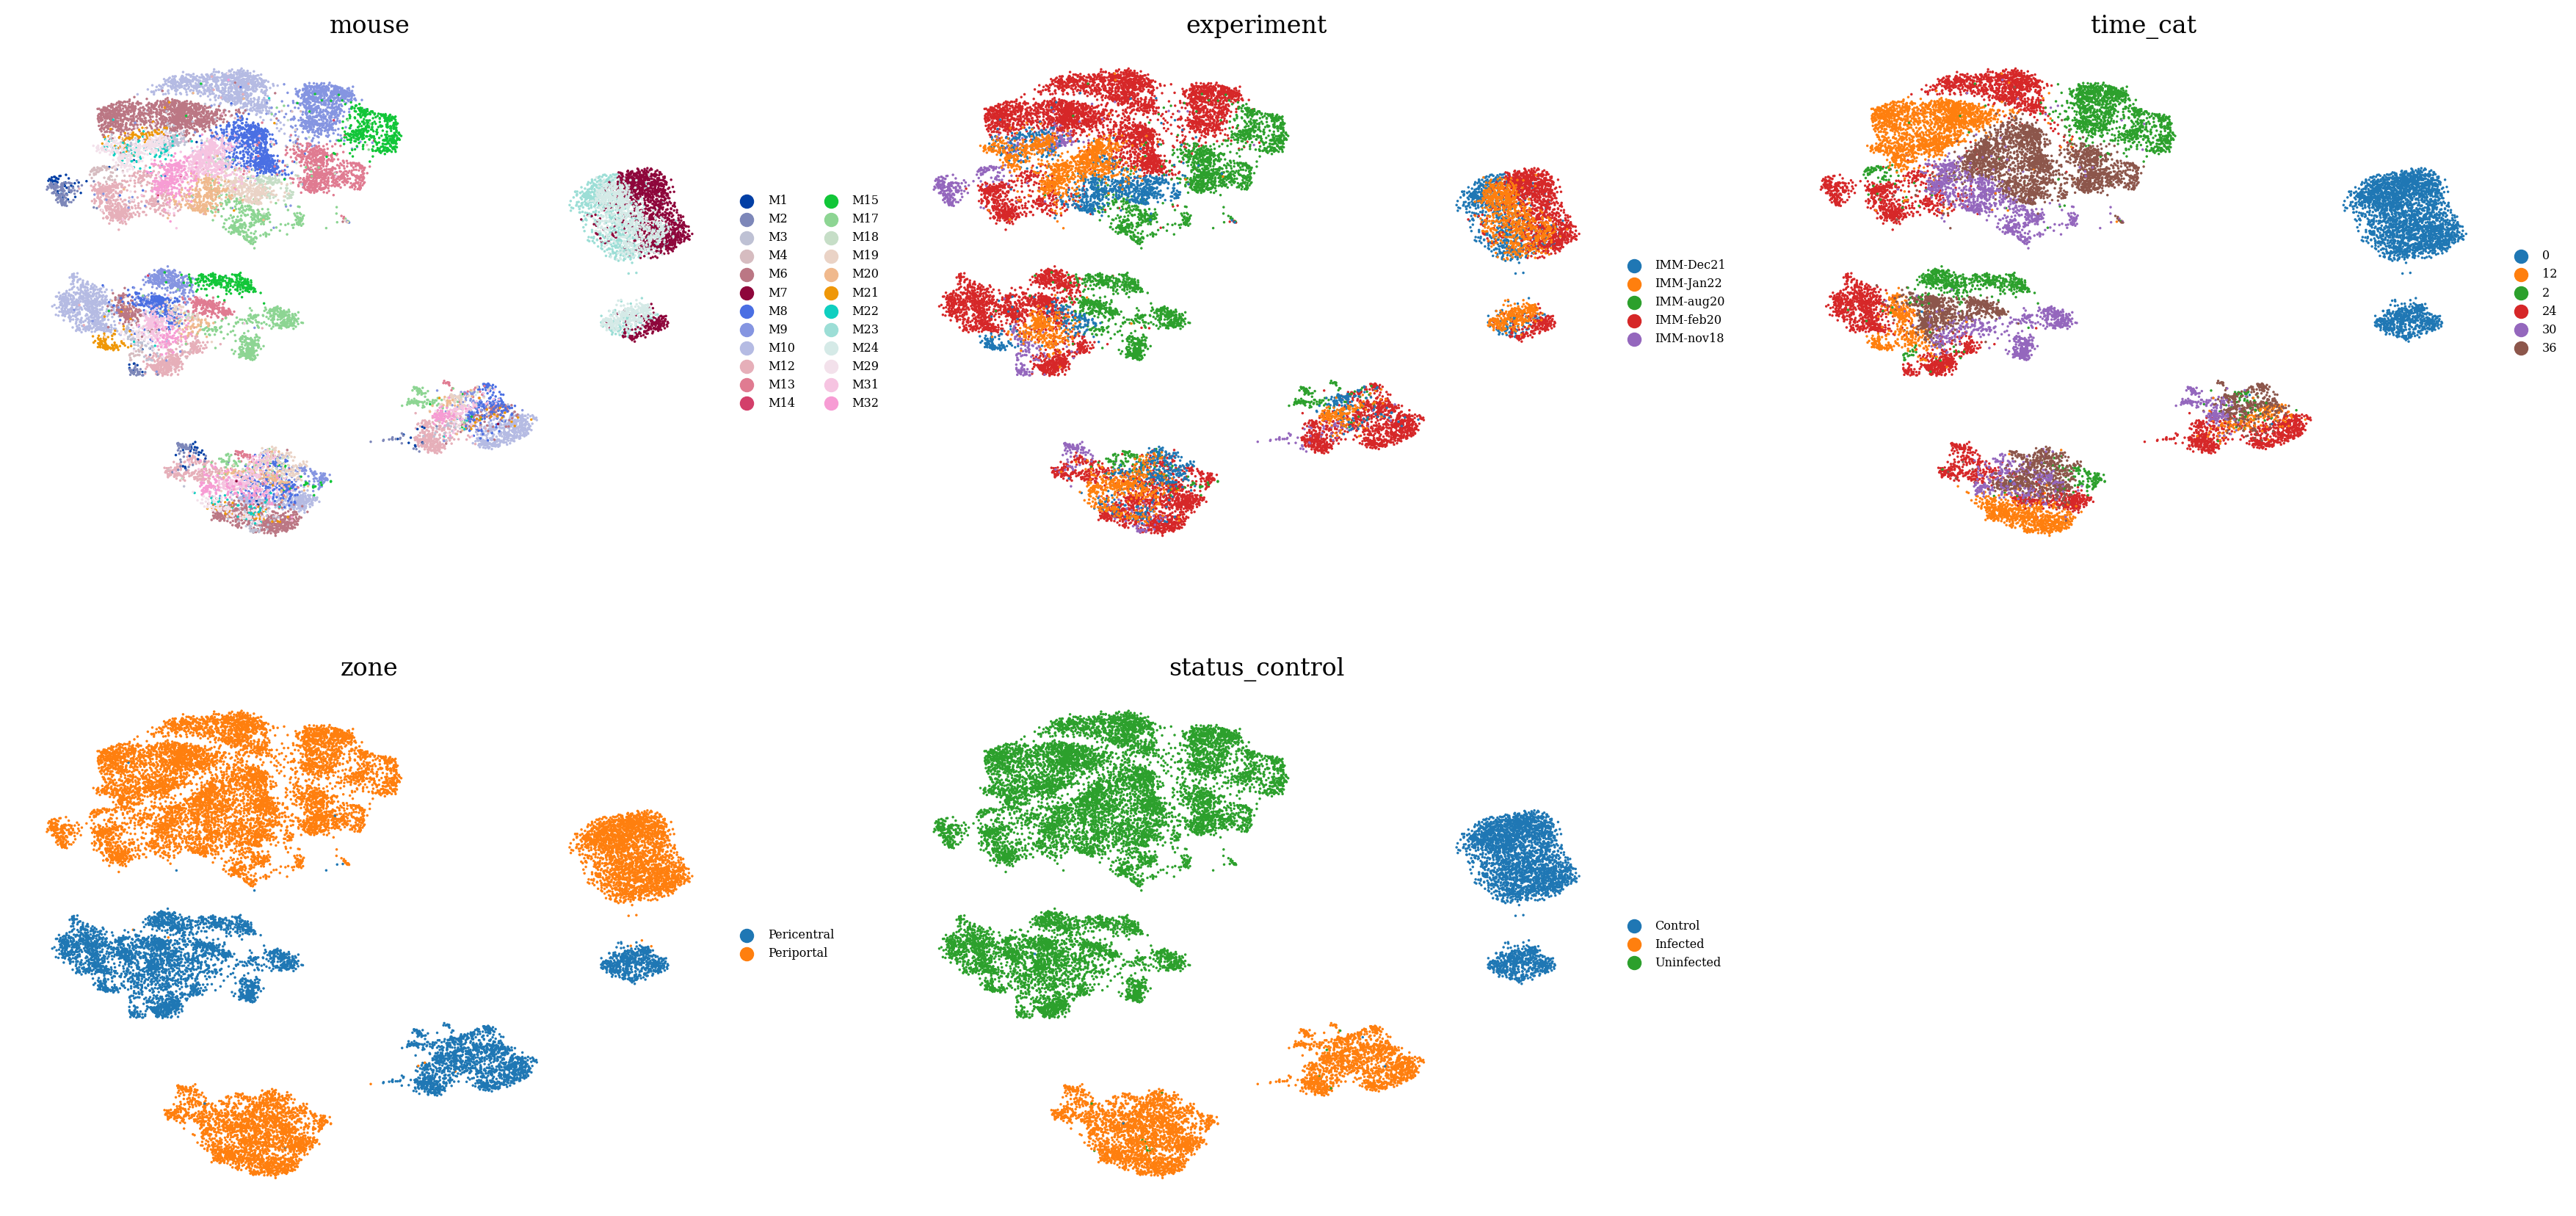

In [18]:
sc.pp.neighbors(latents["latent_after"])
sc.tl.umap(latents["latent_after"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_after"], 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control'], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

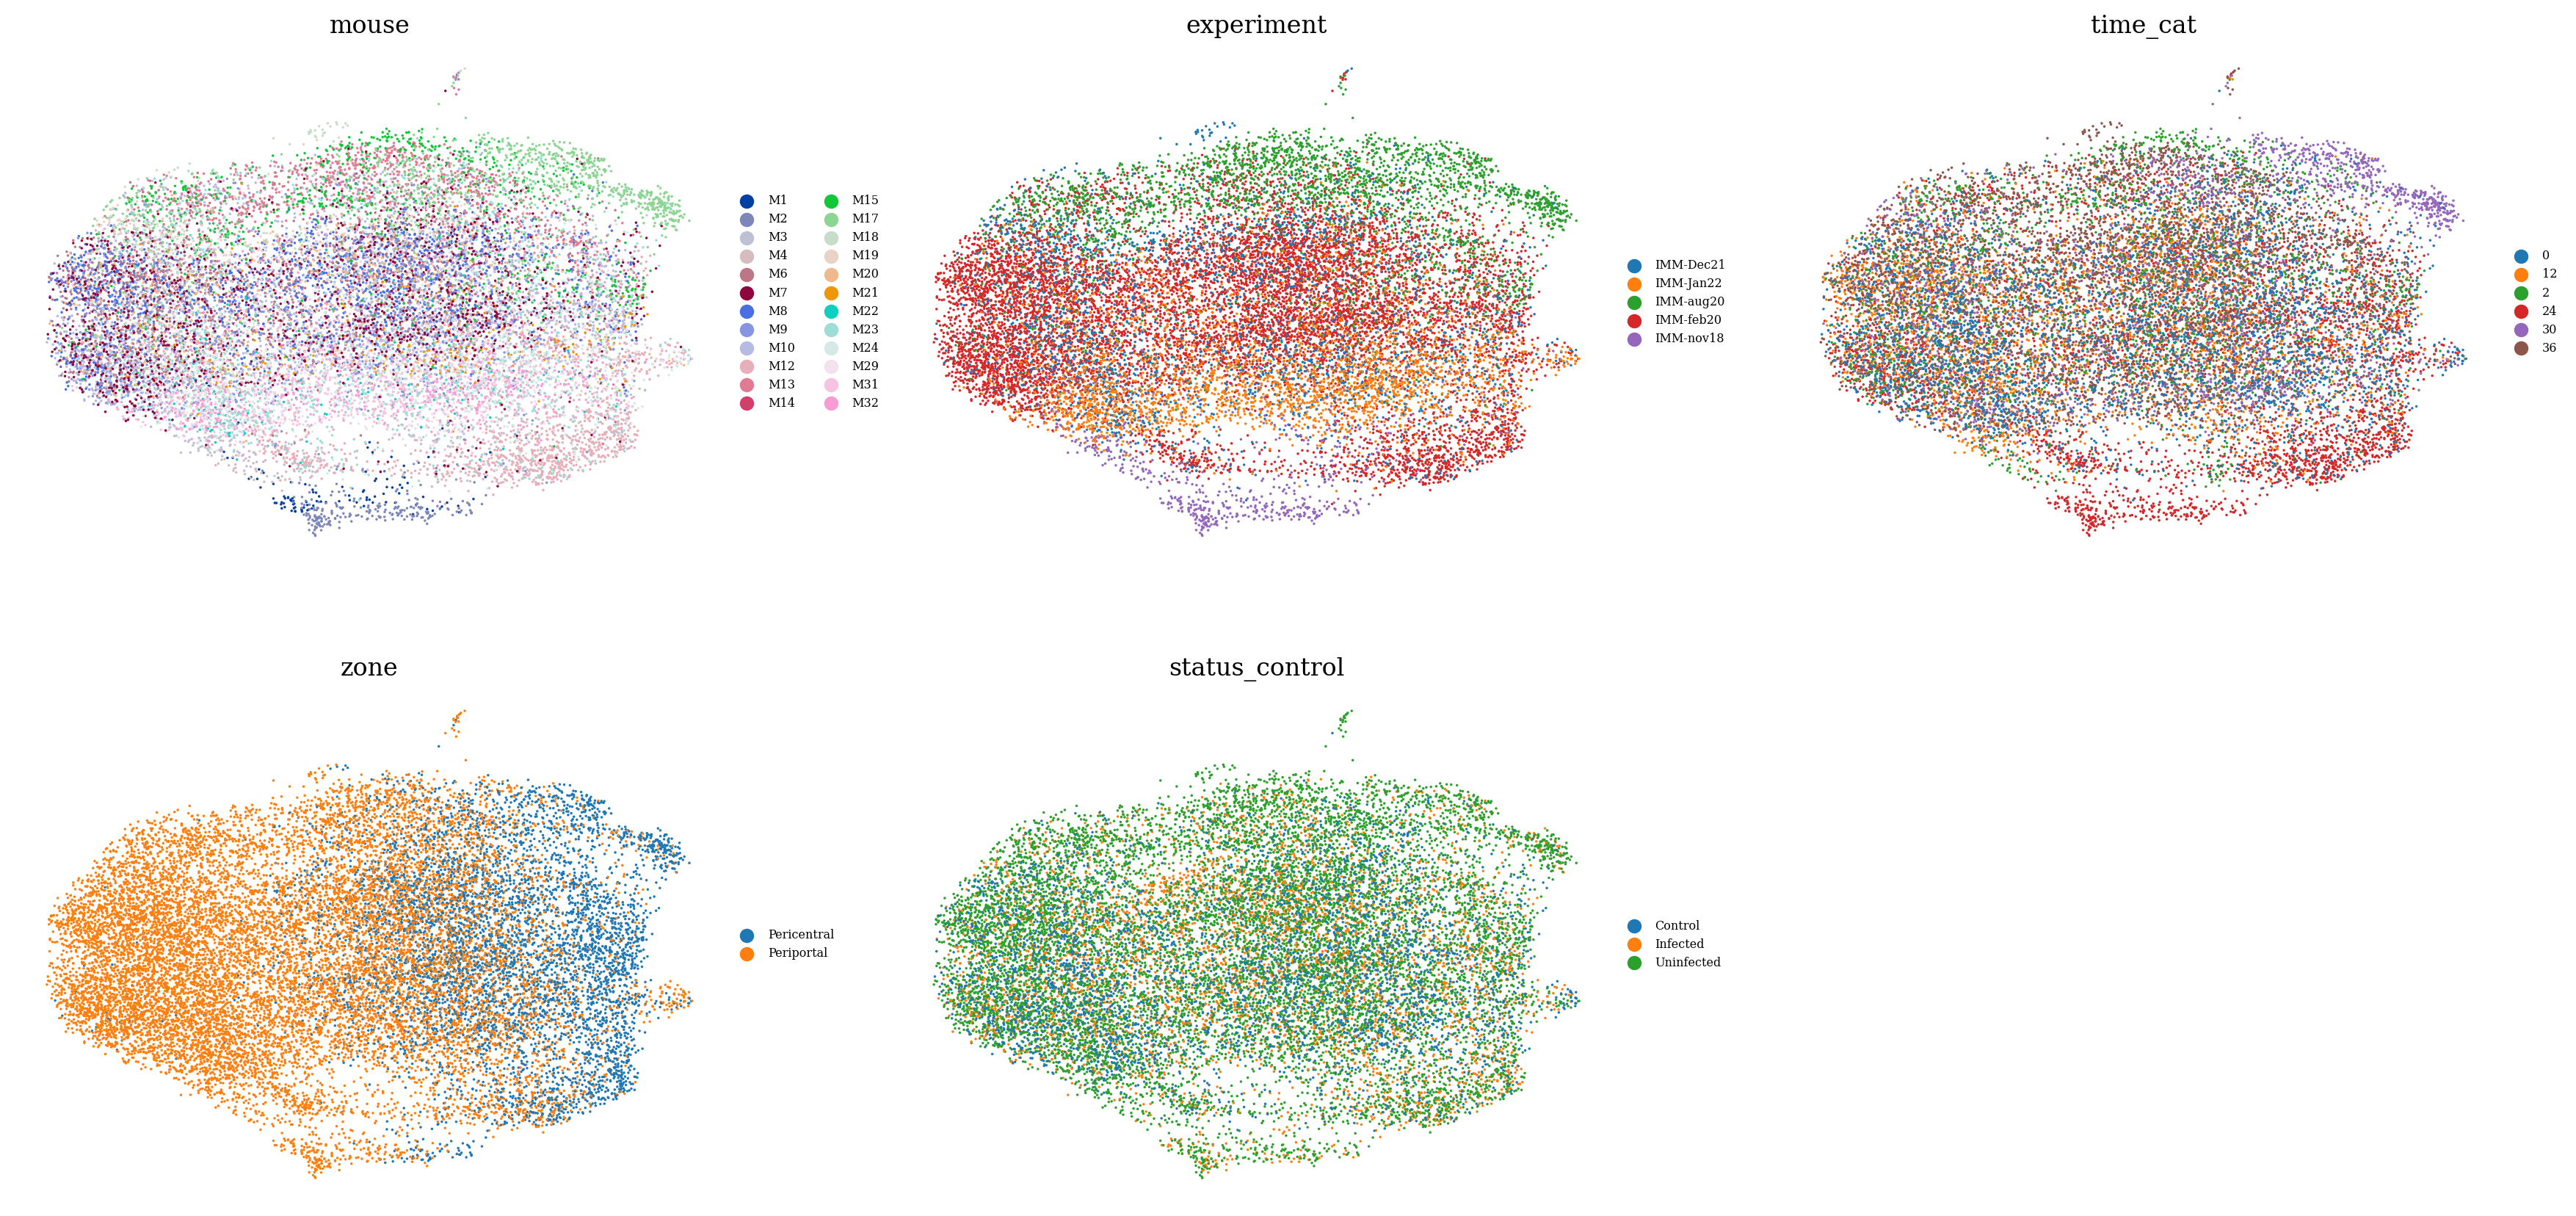

In [19]:
sc.pp.neighbors(latents["latent_basal"])
sc.tl.umap(latents["latent_basal"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_basal"], 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control'], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [20]:
model.predict()

  0%|          | 0/596 [00:00<?, ?it/s]

  0%|          | 1/596 [00:00<02:31,  3.93it/s]

  4%|▍         | 26/596 [00:00<00:06, 92.25it/s]

  9%|▊         | 52/596 [00:00<00:03, 147.13it/s]

 13%|█▎        | 78/596 [00:00<00:02, 181.33it/s]

 17%|█▋        | 103/596 [00:00<00:02, 202.83it/s]

 21%|██▏       | 128/596 [00:00<00:02, 215.75it/s]

 26%|██▌       | 153/596 [00:00<00:01, 223.43it/s]

 30%|██▉       | 178/596 [00:00<00:01, 228.72it/s]

 34%|███▍      | 202/596 [00:01<00:01, 232.07it/s]

 38%|███▊      | 227/596 [00:01<00:01, 234.64it/s]

 42%|████▏     | 251/596 [00:01<00:01, 236.14it/s]

 46%|████▋     | 276/596 [00:01<00:01, 237.39it/s]

 51%|█████     | 301/596 [00:01<00:01, 238.44it/s]

 55%|█████▍    | 325/596 [00:01<00:01, 238.87it/s]

 59%|█████▊    | 350/596 [00:01<00:01, 239.32it/s]

 63%|██████▎   | 375/596 [00:01<00:00, 239.50it/s]

 67%|██████▋   | 400/596 [00:01<00:00, 239.96it/s]

 71%|███████▏  | 425/596 [00:02<00:00, 239.82it/s]

 76%|███████▌  | 450/596 [00:02<00:00, 238.81it/s]

 80%|███████▉  | 475/596 [00:02<00:00, 239.53it/s]

 84%|████████▍ | 500/596 [00:02<00:00, 239.82it/s]

 88%|████████▊ | 525/596 [00:02<00:00, 240.32it/s]

 92%|█████████▏| 550/596 [00:02<00:00, 240.35it/s]

 96%|█████████▋| 575/596 [00:02<00:00, 240.85it/s]

100%|██████████| 596/596 [00:02<00:00, 219.71it/s]

In [21]:
pred_adata = adata[model.test_indices]
true = np.array(pred_adata.X)
pred = np.array(pred_adata.obsm["CPA_pred"])

In [22]:
batch_size = 32

r2s = []
start_ind = 0
for end_ind in range(batch_size, len(true), batch_size):
    print(start_ind, end_ind)
    t = true[start_ind:end_ind]
    p = pred[start_ind:end_ind]
    r2 = sklearn.metrics.r2_score(y_true=t.mean(axis=0), y_pred=p.mean(axis=0))
    r2s.append(r2)
    start_ind = end_ind


0

32

32

64

64

96

96

128

128

160

In [23]:
np.mean(r2s)

0.9812531853885098

In [24]:
dir_path_latent = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/_temporary/latent",
    f"afriat_cpa_ood-seed-{ood_seed}_size-{num_ood}.h5ad"
)
adata.write_h5ad(dir_path_latent)